# 1. Загрузка библиотек и глобальных переменны

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import seaborn as sns
import Levenshtein
import matplotlib.pyplot as plt
import matplotlib.dates
from scipy.stats import shapiro
from datetime import datetime
from scipy.stats import f_oneway
DIR = '/content/drive/MyDrive/'
DIR = './'

### 1.1. Пользовательские функции

In [2]:
def check_data(data_df):
    print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
    print(data_df.info())
    # print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum(
    )/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis=1) > 0)/data_df.shape[0]
    print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
    print('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print('Доля пропусков: {:.1%}'.format(missed_cells) + '\033[0m')
    print('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    # Проверим дубликаты
    print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    # Посмотрим на сами данные
    print('\033[1m' + '\nПервые пять строк датасета' + '\033[0m')
    display(data_df.head(10))  # tail(7)

    print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:' + '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_' + str(i) + '\033[0m')
        display(data_df[i].value_counts())


plt.show()




In [3]:
def find_similar_strings(df_main):
    implicit_duplicates = []
    reference_string = None
    threshold_distance = 3  # Пороговое значение для считывания строки как дубликата
    for index, string in df_main.iterrows():
        if reference_string is None:
            reference_string = string
            continue
        distance = Levenshtein.distance(reference_string, string)
        if distance < threshold_distance:
            implicit_duplicates.append((reference_string, string))
        else:
            reference_string = string
    return implicit_duplicates

In [4]:
def cat_graph(df, cat_feat):
    '''
    Функция отрисовки круговых диаграмм для категориальных переменных.
    На вход: исходная таблица и список категориальных переменных.
    На выходе: графики
    '''

    cols = 2
    rows = int(np.ceil(len(cat_feat) / cols))

    fig, axs = plt.subplots(rows, cols, figsize=(25, 20))
    plt.tight_layout()

    count = -1
    for i in range(rows):
        for x in range(cols):
            count += 1
            col = cat_feat[count]
            df1 = pd.DataFrame(df.groupby([col])[col].count())
            axs[i, x].pie(x=df1[col],
                          labels=df1.index,
                          autopct='%1.1f%%',)
            axs[i, x].title.set_text(str(col))

    plt.suptitle('Круговые диаграммы категориальных признаков',
                 fontsize=20, y=1.03)

    plt.show()

In [5]:
def plot_hist(data, col_column):
    '''
    Функция отрисовки гистограмм и ящика с усами для количесвтенных переменных.
    На вход: исходная таблица и список количественных переменных.
    На выходе: графики
    '''
    rows = len(col_column)
    f, ax = plt.subplots(rows,2, figsize=(8, 15))
    f.tight_layout()
    f.set_figheight(30)
    f.set_figwidth(14)
    plt.rcParams.update({'font.size': 18})
    
    for i, col in enumerate(col_column):         
        sns.histplot(data[col], kde=True, bins=24, ax = ax[i, 0])                    
        sns.boxplot(data[col], ax = ax[i, 1])

        ax[i, 0].set_xlabel(col)
        ax[i, 1].set_xlabel(col)
        ax[i, 0].set_ylabel('Количество')
    plt.suptitle("Гистограмма и ящик с усами для количесвтенных данных", fontsize=22, y=1.01)
    plt.show()

In [6]:
def normal_sum_test(x, Ptest):
    """
    Функция проверяет нормальность/ненормальность распределения
    по сумме 3-х тестов: Шапиро, Андерсона-Дарлинга, Харке-Бера

    На выходе:
    1 - ненормальное распределение
    0 - нормальное распредление

    Принцип большинства заложен.
    Внутри есть функция расчёта критерия Андерсона, исходя из уровня значимсоти
    """

    def anderson_chois_sig(A, Ptest):
        if Ptest == 0.05:
            ander = A[2]
        elif Ptest == 0.01:
            ander = A[4]
        return ander

    def normalnost_anderson(x, Ptest):
        A2, crit, sig = anderson(x, dist='norm')
        ad_pass = (A2 < crit)
        norm = anderson_chois_sig(ad_pass, Ptest)
        if norm == False:
            return 1
        return 0
   # print(x)
    p_shapiro = shapiro(x)[1]
    p_jarque = jarque_bera(x)[1]

    if p_shapiro < Ptest:
        p_shapiros = 1
    else:
        p_shapiros = 0

    if p_jarque < Ptest:
        p_jarques = 1
    else:
        p_jarques = 0

    p_anderson = normalnost_anderson(x, Ptest)  # 1 - ненормальное, 0 - нормальное

    p_sum = p_shapiros + p_anderson + p_jarques

    if (p_sum > 1):
        return 1
    else:
        return 0

### 1.2. Загрузка данных

In [7]:
df_main = pd.read_csv("rides.csv")

In [8]:
# Проверка отработанного кода
df_main

Id           Start Date             End Date Start Location  \
0       100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1       100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2       100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3       100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4       100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   
...        ...                  ...                  ...            ...   
102250  197707  2023-07-31 23:45:06  2023-08-01 00:06:55        Озерная   
102251  197708  2023-07-31 23:46:01  2023-08-01 00:25:35       Мичурина   
102252  197709  2023-07-31 23:48:04  2023-08-01 00:09:21     Лермонтова   
102253  197710  2023-07-31 23:51:41  2023-08-01 00:38:04      Рябиновая   
102254  197711  2023-07-31 23:57:01  2023-08-01 00:19:03     Молодежная   

         Start District  End Location     End District  Distance  Promo  
0         Юго-Восточный       Майская      Октябрьский    4069.0      0  
1              заречный    Спортивная      октябрьский    4515.0      0  
2           Октябрьский      Суворова        ленинский    4520.0      0  
3           Центральный       Рабочая  Северо-Западный    3881.0      0  
4       Северо-Западный     Юбилейная    Юго-Восточный    4029.0      0  
...                 ...           ...              ...       ...    ...  
102250    Юго-Восточный  Первомайская  Северо-Западный    3302.0      0  
102251        Ленинский       Садовая         Заречный    4992.0      0  
102252        ленинский     Куйбышева      Центральный    2781.0      0  
102253  Северо-Западный   Энергетиков    Юго-Восточный    6466.0      0  
102254    Юго-Восточный   Маяковского      Центральный    3561.0      0  

[102255 rows x 9 columns]

In [9]:
df_weather = pd.read_csv("weather.csv")

In [10]:
# Проверка отработанного кода
df_weather

Datetime Temperature Precipitation Total  Wind Gust  \
0                     NaN          °C                  mm       km/h   
1     2023-04-01T00:00:00    8.740245                 0.1       48.6   
2     2023-04-01T01:00:00    9.040245                 0.2      55.44   
3     2023-04-01T02:00:00    8.880245                 0.3       55.8   
4     2023-04-01T03:00:00    8.690246                 0.3      55.44   
...                   ...         ...                 ...        ...   
3668  2023-08-31T19:00:00   16.940245                   0  10.799999   
3669  2023-08-31T20:00:00   16.630245                   0  11.159999   
3670  2023-08-31T21:00:00   17.080246                 0.1      17.64   
3671  2023-08-31T22:00:00   17.180244                   0  21.599998   
3672  2023-08-31T23:00:00   17.360245                   0      21.24   

     Wind Speed Cloud Cover Total Sunshine Duration  
0          km/h                 %               min  
1     21.638964                90                 0  
2     22.493519                74                 0  
3      22.26477                72                 0  
4      21.94524                77                 0  
...         ...               ...               ...  
3668       1.08                89         1.4999998  
3669  1.1384199                83                 0  
3670   3.396233                82                 0  
3671  7.2359104                80                 0  
3672  7.2359104                67                 0  

[3673 rows x 7 columns]

# 2. Осмотр данных

### 2.1 Основаня таблица 

In [11]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ
check_data(df_main)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              102255 non-null  int64  
 1   Start Date      102255 non-null  object 
 2   End Date        102255 non-null  object 
 3   Start Location  102255 non-null  object 
 4   Start District  102255 non-null  object 
 5   End Location    102255 non-null  object 
 6   End District    102255 non-null  object 
 7   Distance        101022 non-null  float64
 8   Promo           102255 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 7.0+ MB
None

Проверка пропусков
Количество пропусков: 1233
Доля пропусков: 0.2%
Доля строк содержащих пропуски: 1.2%

Проверка на дубликаты
Количество полных дубликатов:  4883

Первые пять строк датасета


Id           Start Date             End Date Start Location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2  100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3  100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4  100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   
5  100345  2023-04-22 09:10:09  2023-04-22 09:49:56         Лесная   
6  100346  2023-04-22 09:15:12  2023-04-22 09:26:01   Пролетарская   
7  100347  2023-04-22 09:19:13  2023-04-22 09:40:03       Комарова   
8  100348  2023-04-22 09:21:42  2023-04-22 09:39:04       Западная   
9  100349  2023-04-22 09:28:00  2023-04-22 10:02:08        Свободы   

    Start District  End Location     End District  Distance  Promo  
0    Юго-Восточный       Майская      Октябрьский    4069.0      0  
1         заречный    Спортивная      октябрьский    4515.0      0  
2      Октябрьский      Суворова        ленинский    4520.0      0  
3      Центральный       Рабочая  Северо-Западный    3881.0      0  
4  Северо-Западный     Юбилейная    Юго-Восточный    4029.0      0  
5    Юго-Восточный      Западная        Ленинский    4879.0      0  
6      Центральный       Свободы        Ленинский    1846.0      0  
7        Ленинский  ул. западная        Ленинский    3133.0      0  
8        ленинский       Озерная    Юго-Восточный       3.0      0  
9        ленинский   ул. чкалова    юго-восточный    5263.0      0


Описание количественных данных:


count           mean            std       min       25%  \
Id        102255.0  149024.057679   28110.574992  100340.0  124682.5   
Distance  101022.0   27291.098424  309718.565282       1.0    3044.0   
Promo     102255.0       0.019755       0.139156       0.0       0.0   

               50%       75%        max  
Id        149028.0  173372.5   197711.0  
Distance    3702.0    4429.0  7569789.0  
Promo          0.0       0.0        1.0


Описание категориальных данных:


count unique                  top   freq
Start Date      102255  96526  2023-07-15 18:09:14      4
End Date        102255  95949                  NaT    579
Start Location  102255    463           Ломоносова   1675
Start District  102255     13          Центральный  18115
End Location    102255    495           Спортивная   1511
End District    102255     14          Центральный  18878


Вывод уникальных значений по каждому категориаьному признаку:
_Start Date


Start Date
2023-07-15 18:09:14    4
2023-07-02 11:35:14    4
2023-05-13 20:14:28    3
2023-05-15 17:55:10    3
2023-06-18 16:58:14    3
                      ..
2023-05-30 09:14:05    1
2023-05-30 09:11:52    1
2023-05-30 09:11:48    1
2023-05-30 09:11:23    1
2023-07-31 23:57:01    1
Name: count, Length: 96526, dtype: int64

_End Date


End Date
NaT                    579
2023-07-03 20:07:12      4
2023-05-20 19:58:25      4
2023-07-29 15:22:04      4
2023-06-18 18:42:24      4
                      ... 
2023-05-30 10:26:42      1
2023-05-30 10:14:47      1
2023-05-30 10:15:27      1
2023-05-30 10:02:55      1
2023-08-01 00:19:03      1
Name: count, Length: 95949, dtype: int64

_Start Location


Start Location
Ломоносова           1675
Луговая              1655
Майская              1648
Восточная            1584
Спортивная           1583
                     ... 
Ул. Северная            1
Ул. Набережная          1
Ул. Энтузиастов         1
Ул. Матросова           1
Ул. Комсомольская       1
Name: count, Length: 463, dtype: int64

_Start District


Start District
Центральный        18115
Юго-Восточный      13542
Ленинский          11308
Северо-Западный    11304
Октябрьский         9729
центральный         8259
Заречный            6803
юго-восточный       5869
ленинский           5011
северо-западный     4973
октябрьский         4330
заречный            3011
северо западный        1
Name: count, dtype: int64

_End Location


End Location
Спортивная          1511
Восточная           1450
Ломоносова          1441
Буденного           1406
Луговая             1405
                    ... 
Ул. Рябиновая          1
ул октябрьская         1
Ул. Энергетиков        1
Ул. Пролетарская       1
ул матросова           1
Name: count, Length: 495, dtype: int64

_End District


End District
Центральный        18878
Юго-Восточный      14612
Ленинский          12090
Северо-Западный    12055
Октябрьский        10519
Заречный            7023
центральный         6808
юго-восточный       5203
северо-западный     4411
ленинский           4308
октябрьский         3794
заречный            2499
Северо Западный       33
северо западный       22
Name: count, dtype: int64

In [12]:
# ГРАФИЧЕСКИЙ АНАЛИЗ количественных данных данных
num_features = df_main.select_dtypes(exclude=[object]).columns

# Проверка
num_features

Index(['Id', 'Distance', 'Promo'], dtype='object')

*Вывод: Отсутвует время начала и время конца поездки*

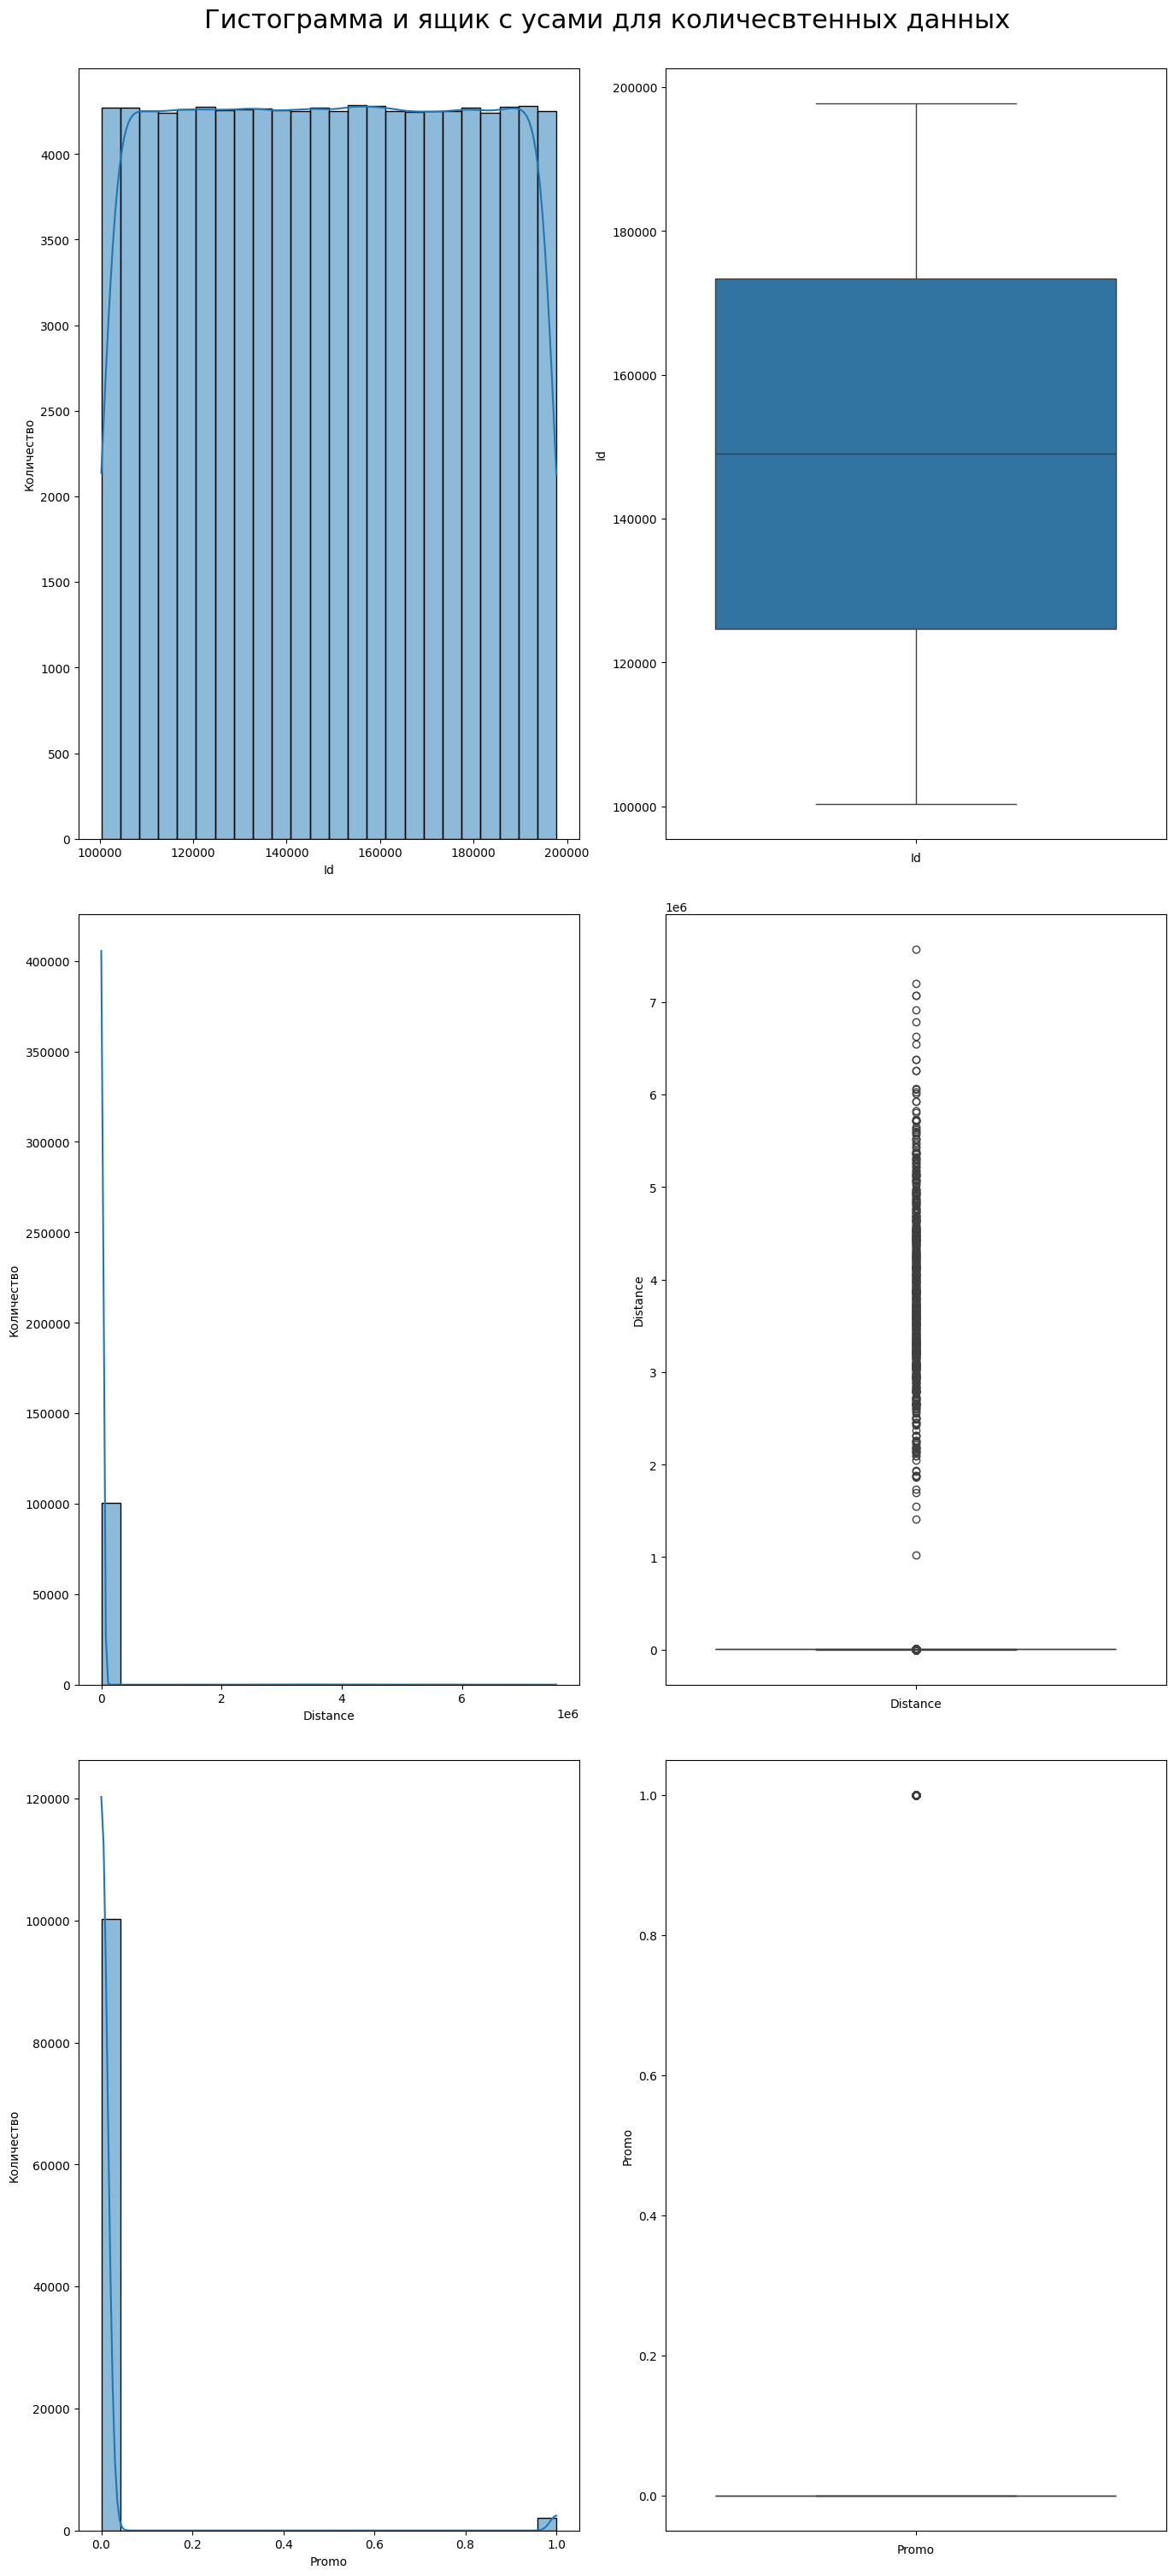

In [13]:
plot_hist(df_main, df_main.select_dtypes(exclude=[object]).columns)

In [14]:
# cat_graph(df_main, df_main.select_dtypes(include=[object]).columns) Не работает не понятно по чему. После обработки данных работет

In [15]:
# ГРАФИЧЕСКИЙ АНАЛИЗ категориальных данных
cat_features = df_main.select_dtypes(include=[object]).columns

# Проверка
cat_features

Index(['Start Date', 'End Date', 'Start Location', 'Start District',
       'End Location', 'End District'],
      dtype='object')

*Вывод: Есть лишние данные в виде даты старта и даты окончания*

In [16]:
# cat_graph(df_main, df_main.select_dtypes(include=[object]).columns)

### 2.2 Таблица с погодой

In [17]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ
check_data(df_weather)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Datetime             3672 non-null   object
 1   Temperature          3618 non-null   object
 2   Precipitation Total  3643 non-null   object
 3   Wind Gust            3673 non-null   object
 4   Wind Speed           3657 non-null   object
 5   Cloud Cover Total    3653 non-null   object
 6   Sunshine Duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB
None

Проверка пропусков
Количество пропусков: 134
Доля пропусков: 0.6%
Доля строк содержащих пропуски: 3.6%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


Datetime Temperature Precipitation Total  Wind Gust Wind Speed  \
0                  NaN          °C                  mm       km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1       48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2      55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3       55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3      55.44   21.94524   
5  2023-04-01T04:00:00    8.630245                 0.3      48.96   22.42427   
6  2023-04-01T05:00:00    8.430245                 0.5       48.6   22.91026   
7  2023-04-01T06:00:00    8.690246                 0.3  50.039997    23.1774   
8  2023-04-01T07:00:00    8.860246                 0.4      52.56  23.166216   
9  2023-04-01T08:00:00    8.640245                 0.5         63  20.371038   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0  
5                78                 0  
6                77                 0  
7                98         0.5287884  
8                89          6.060605  
9                92          4.242425


Описание количественных данных:


count unique                  top  freq
Datetime             3672   3672  2023-04-01T00:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


Описание категориальных данных:


count unique                  top  freq
Datetime             3672   3672  2023-04-01T00:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


Вывод уникальных значений по каждому категориаьному признаку:
_Datetime


Datetime
2023-04-01T00:00:00    1
2023-07-11T15:00:00    1
2023-07-11T17:00:00    1
2023-07-11T18:00:00    1
2023-07-11T19:00:00    1
                      ..
2023-05-22T03:00:00    1
2023-05-22T04:00:00    1
2023-05-22T05:00:00    1
2023-05-22T06:00:00    1
2023-08-31T23:00:00    1
Name: count, Length: 3672, dtype: int64

_Temperature


Temperature
27.540245    9
15.040245    8
25.610245    8
11.250245    7
15.130245    6
            ..
14.130245    1
12.330245    1
13.260245    1
14.000245    1
19.980246    1
Name: count, Length: 1964, dtype: int64

_Precipitation Total


Precipitation Total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
0.6      38
0.5      33
0.8      23
0.7      21
1.2      15
1.3      15
0.9      13
1.1      12
1.4      10
1         8
1.6       7
1.5       7
2.2       6
1.8       6
1.7       6
2.1       4
2.4       2
2.6       2
2.3       2
2         2
1.9       2
2.8       1
3.4       1
3.9       1
mm        1
3.3       1
3         1
5         1
5.8       1
2.9       1
2.7       1
Name: count, dtype: int64

_Wind Gust


Wind Gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
3.2399998      1
2.8799999      1
60.479996      1
59.76          1
58.679996      1
Name: count, Length: 163, dtype: int64

_Wind Speed


Wind Speed
4.3349743     36
5.3517847     34
6.28713       33
3.319036      33
4.1046314     32
              ..
15.2947035     1
9.9571085      1
16.981165      1
16.563911      1
19.64228       1
Name: count, Length: 709, dtype: int64

_Cloud Cover Total


Cloud Cover Total
0            251
100           97
1             56
98            48
20            45
            ... 
69.400002      1
79.7           1
66.400002      1
5.1000004      1
%              1
Name: count, Length: 197, dtype: int64

_Sunshine Duration


Sunshine Duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
6.729798        1
6.280404        1
6.886363        1
1.3969697       1
1.4999998       1
Name: count, Length: 495, dtype: int64

In [18]:
# ГРАФИЧЕСКИЙ АНАЛИЗ количественных данных данных
num_features = df_weather.select_dtypes(exclude=[object]).columns

# Проверка
num_features

Index([], dtype='object')

In [19]:
# ГРАФИЧЕСКИЙ АНАЛИЗ категориальных данных
cat_features = df_weather.select_dtypes(include=[object]).columns

# Проверка
cat_features

Index(['Datetime', 'Temperature', 'Precipitation Total', 'Wind Gust',
       'Wind Speed', 'Cloud Cover Total', 'Sunshine Duration'],
      dtype='object')

*Вывод: Не правильно назначенны типы данных*

In [20]:
# cat_graph(df_main, df_main.select_dtypes(include=[object]).columns)

### 2.3 Выводы

**Основная таблица:** 
* Есть дубли.
* Привести названия столбцов в соответствие с требованием питона.
* Есть выбросы в distanse.
* Есть пропуски.
* Есть NaN.
* Не правильно обозначенны типы данных.
* Дописать выводы!!

# 3. Подготовка данных

### 3.1 Основаня таблица 

In [21]:
# Приводим к PEP-8 Названия столбов
df_main.columns = df_main.columns.str.lower().str.replace(' ', '_')

In [22]:
# ПРОВЕРКА ОТРАБОТКИ КОДА
df_main.head(1)

id           start_date             end_date start_location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   

  start_district end_location end_district  distance  promo  
0  Юго-Восточный      Майская  Октябрьский    4069.0      0

*Вывод: всё нормально*

In [23]:
# Заполняем Пропуски NaN
df_main.fillna(np.nan, inplace=True)

In [24]:
# Приводим 'start_location' и 'end_location' к уникальным занчениям без повтроения.
def to_normal(means):
    means = means.lower()
    means = means.replace(' ', '')
    means = means.replace('ул', 'ул.')
    means = means.replace('ул..', 'ул.')
    means = means.replace('ул.', '')
    
    return means


df_main['start_location'] = df_main['start_location'].apply(to_normal)
df_main['end_location'] = df_main['end_location'].apply(to_normal)

In [25]:
# Приводим 'start_district' и 'end_district' к уникальным занчениям без повтроения.
replc = {
    'Северо-Западный': 'Северо-Западный',
    'северо западный': 'Северо-Западный',
    'северо-западный': 'Северо-Западный',
    'Северо Западный': 'Северо-Западный',
    'Юго-Восточный': 'Юго-Восточный',
    'юго-восточный': 'Юго-Восточный',
    'Ленинский': 'Ленинский',
    'ленинский': 'Ленинский',
    'Октябрьский': 'Октябрьский',
    'октябрьский ': 'Октябрьский',
    'Центральный': 'Центральный',
    'центральный': 'Центральный',
    'Заречный': 'Заречный',
    'заречный': 'Заречный',
    'ленинский': 'Ленинский',
    'Ленинский': 'Ленинский',
    'октябрьский': 'Октябрьский',
    'Октябрьский': 'Октябрьский',

}

# Проходим по столбцу 'категория' и заменяем значения согласно словарю замен
df_main['start_district'] = df_main['start_district'].replace(replc)
df_main['end_district'] = df_main['end_district'].replace(replc)

In [26]:
# Проверяем что остались только уникальные занчения и потоврений больше нет.
print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
df_object = df_main.select_dtypes(include='object').columns
for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(df_main[i].value_counts())


Вывод уникальных значений по каждому категориаьному признаку:
_start_date


start_date
2023-07-15 18:09:14    4
2023-07-02 11:35:14    4
2023-05-13 20:14:28    3
2023-05-15 17:55:10    3
2023-06-18 16:58:14    3
                      ..
2023-05-30 09:14:05    1
2023-05-30 09:11:52    1
2023-05-30 09:11:48    1
2023-05-30 09:11:23    1
2023-07-31 23:57:01    1
Name: count, Length: 96526, dtype: int64

_end_date


end_date
NaT                    579
2023-07-03 20:07:12      4
2023-05-20 19:58:25      4
2023-07-29 15:22:04      4
2023-06-18 18:42:24      4
                      ... 
2023-05-30 10:26:42      1
2023-05-30 10:14:47      1
2023-05-30 10:15:27      1
2023-05-30 10:02:55      1
2023-08-01 00:19:03      1
Name: count, Length: 95949, dtype: int64

_start_location


start_location
ломоносова    2414
луговая       2397
майская       2342
восточная     2312
спортивная    2311
              ... 
речная         844
дружбы         842
сиреневая      832
набережная     827
мира           811
Name: count, Length: 91, dtype: int64

_start_district


start_district
Центральный        26374
Юго-Восточный      19411
Ленинский          16319
Северо-Западный    16278
Октябрьский        14059
Заречный            9814
Name: count, dtype: int64

_end_location


end_location
спортивная    2449
восточная     2392
буденного     2390
луговая       2379
майская       2356
              ... 
дачная         822
набережная     819
нагорная       817
куйбышева      815
пушкина        738
Name: count, Length: 91, dtype: int64

_end_district


end_district
Центральный        25686
Юго-Восточный      19815
Северо-Западный    16521
Ленинский          16398
Октябрьский        14313
Заречный            9522
Name: count, dtype: int64

In [27]:
pd.set_option('display.max_rows', 20)
# Находим явыне дубликаты и удаляем их 
dulc = df_main.duplicated(keep=False)
#Все явыне дубликаты 
df_main[dulc]

id           start_date             end_date start_location  \
16      100356  2023-04-22 09:44:41  2023-04-22 10:23:10    энтузиастов   
17      100356  2023-04-22 09:44:41  2023-04-22 10:23:10    энтузиастов   
44      100383  2023-04-22 10:33:56  2023-04-22 10:58:41     ломоносова   
45      100383  2023-04-22 10:33:56  2023-04-22 10:58:41     ломоносова   
81      100419  2023-04-22 11:31:18  2023-04-22 12:03:19      цветочная   
...        ...                  ...                  ...            ...   
102181  197640  2023-07-31 21:43:19  2023-07-31 21:58:08         кирова   
102183  197642  2023-07-31 21:44:24  2023-07-31 22:13:12      восточная   
102184  197642  2023-07-31 21:44:24  2023-07-31 22:13:12      восточная   
102204  197662  2023-07-31 21:57:30  2023-07-31 22:26:37       дорожная   
102205  197662  2023-07-31 21:57:30  2023-07-31 22:26:37       дорожная   

         start_district  end_location   end_district  distance  promo  
16          Центральный     сиреневая  Юго-Восточный    4715.0      0  
17          Центральный     сиреневая  Юго-Восточный    4715.0      0  
44          Октябрьский     матросова    Центральный    3907.0      0  
45          Октябрьский     матросова    Центральный    3907.0      0  
81      Северо-Западный  коммунальная  Юго-Восточный    4801.0      0  
...                 ...           ...            ...       ...    ...  
102181        Ленинский  коммунальная  Юго-Восточный    2809.0      0  
102183      Октябрьский    спортивная    Октябрьский    2696.0      0  
102184      Октябрьский    спортивная    Октябрьский    2696.0      0  
102204    Юго-Восточный     сиреневая  Юго-Восточный    3700.0      0  
102205    Юго-Восточный     сиреневая  Юго-Восточный    3700.0      0  

[9766 rows x 9 columns]

In [28]:
# Функция для определения неявных дубликатов на основе расстояния Левенштейна
find_similar_strings(df_main)

c:\Python311\Lib\site-packages\Levenshtein\__init__.py:123: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return _Levenshtein.distance(


[(id                             100356
  start_date        2023-04-22 09:44:41
  end_date          2023-04-22 10:23:10
  start_location            энтузиастов
  start_district            Центральный
  end_location                сиреневая
  end_district            Юго-Восточный
  distance                       4715.0
  promo                               0
  Name: 16, dtype: object,
  id                             100356
  start_date        2023-04-22 09:44:41
  end_date          2023-04-22 10:23:10
  start_location            энтузиастов
  start_district            Центральный
  end_location                сиреневая
  end_district            Юго-Восточный
  distance                       4715.0
  promo                               0
  Name: 17, dtype: object),
 (id                             100383
  start_date        2023-04-22 10:33:56
  end_date          2023-04-22 10:58:41
  start_location             ломоносова
  start_district            Октябрьский
  end_location           

Как мы можем заметить этих дубликатов различаеться только время окончания поездки.

In [29]:
# Удалим дуликаты.
dulc = df_main.drop_duplicates(subset=['id', 'start_date', 'start_location',
                               'start_district', 'end_location', 'end_district', 'distance', 'promo'], keep='first', inplace=True)

In [30]:
# Заполняем пропуски в distance
df_main['start_date'] = pd.to_datetime(df_main['start_date'])
df_main['end_date'] = pd.to_datetime(df_main['end_date'])


# Преобразуем столбцы с датами в формат datetime
df_main['start_date'] = pd.to_datetime(df_main['start_date'])
df_main['end_date'] = pd.to_datetime(df_main['end_date'])

# Вычисляем время, затраченное на поездку, в минутах
df_main['Travel Time'] = (df_main['end_date'] -
                          df_main['start_date']).dt.total_seconds() / 60 / 60

# Вычисляем среднюю скорость
average_speed = df_main['distance'].median() / df_main['Travel Time'].median()

# Заполняем пропуски в столбце Distance средним значением скорости
df_main['distance'].fillna(df_main['Travel Time'] *
                           average_speed, inplace=True)

In [31]:
# Заполняем пропущенное end_date

# Вычисляем медиану времени поездки и медиану расстояния
median_travel_time = df_main['Travel Time'].median()
median_distance = df_main['distance'].median()

# Заполняем пропуски в столбце Travel Time медианным значением времени поездки
df_main['Travel Time'].fillna(median_travel_time, inplace=True)

# Вычисляем медиану скорости
median_speed_m_per_min = median_distance / median_travel_time

# Заполняем пропуски в столбце End Date с использованием медианной скорости
df_main['end_date'].fillna(df_main['start_date'] + pd.to_timedelta(
    df_main['Travel Time'] / median_speed_m_per_min, unit='min'), inplace=True)

# Округляем значения до ближайшего целого числа end_date
df_main['end_date'] = df_main['end_date'].dt.floor('min')

# Округляем значения до ближайшего целого числа start_date
df_main['start_date'] = df_main['start_date'].dt.floor('min')

# Удаляем временный столбец с временем поездки
df_main.drop('Travel Time', axis=1, inplace=True)

In [32]:
#Убираем выбросы
# Использование межквартильного размаха для удаления выбросов из столбца 'Distance'
Q1 = df_main['distance'].quantile(0.25)
Q3 = df_main['distance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов
df_main = df_main[(df_main['distance'] > lower_bound) & (df_main['distance'] < upper_bound)]

In [33]:
check_data(df_main)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Index: 92611 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              92611 non-null  int64         
 1   start_date      92611 non-null  datetime64[ns]
 2   end_date        92611 non-null  datetime64[ns]
 3   start_location  92611 non-null  object        
 4   start_district  92611 non-null  object        
 5   end_location    92611 non-null  object        
 6   end_district    92611 non-null  object        
 7   distance        92611 non-null  float64       
 8   promo           92611 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 7.1+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


id          start_date            end_date start_location  \
0   100340 2023-04-22 09:01:00 2023-04-22 09:24:00       шевченко   
1   100341 2023-04-22 09:01:00 2023-04-22 09:29:00         чехова   
2   100342 2023-04-22 09:04:00 2023-04-22 09:42:00      буденного   
3   100343 2023-04-22 09:06:00 2023-04-22 09:38:00          труда   
4   100344 2023-04-22 09:09:00 2023-04-22 09:40:00   первомайская   
5   100345 2023-04-22 09:10:00 2023-04-22 09:49:00         лесная   
6   100346 2023-04-22 09:15:00 2023-04-22 09:26:00   пролетарская   
7   100347 2023-04-22 09:19:00 2023-04-22 09:40:00       комарова   
9   100349 2023-04-22 09:28:00 2023-04-22 10:02:00        свободы   
10  100350 2023-04-22 09:37:00 2023-04-22 09:52:00   коммунальная   

     start_district end_location     end_district  distance  promo  
0     Юго-Восточный      майская      Октябрьский    4069.0      0  
1          Заречный   спортивная      Октябрьский    4515.0      0  
2       Октябрьский     суворова        Ленинский    4520.0      0  
3       Центральный      рабочая  Северо-Западный    3881.0      0  
4   Северо-Западный    юбилейная    Юго-Восточный    4029.0      0  
5     Юго-Восточный     западная        Ленинский    4879.0      0  
6       Центральный      свободы        Ленинский    1846.0      0  
7         Ленинский     западная        Ленинский    3133.0      0  
9         Ленинский      чкалова    Юго-Восточный    5263.0      0  
10    Юго-Восточный   строителей      Центральный    2731.0      0


Описание количественных данных:


count                           mean                  min  \
id          92611.0                  149049.120234             100340.0   
start_date    92611  2023-06-13 21:39:52.406301184  2023-04-22 09:01:00   
end_date      92611  2023-06-13 22:05:48.801546240  2023-04-22 09:24:00   
distance    92611.0                    3780.493506                969.0   
promo       92611.0                       0.019771                  0.0   

                            25%                  50%                  75%  \
id                     124683.5             149064.0             173384.5   
start_date  2023-05-20 21:42:00  2023-06-14 16:02:00  2023-07-08 19:57:00   
end_date    2023-05-20 22:08:30  2023-06-14 16:28:00  2023-07-08 20:23:00   
distance                 3098.0               3718.0               4410.0   
promo                       0.0                  0.0                  0.0   

                            max           std  
id                     197711.0  28114.505524  
start_date  2023-07-31 23:57:00           NaN  
end_date    2023-08-01 00:42:00           NaN  
distance                 6512.0    959.564389  
promo                       1.0      0.139213


Описание категориальных данных:


count unique          top   freq
start_location  92611     91   ломоносова   2207
start_district  92611      6  Центральный  24082
end_location    92611     91   спортивная   2232
end_district    92611      6  Центральный  23520


Вывод уникальных значений по каждому категориаьному признаку:
_start_location


start_location
ломоносова     2207
луговая        2205
майская        2161
спортивная     2112
буденного      2104
               ... 
набережная      768
молодежная      761
энтузиастов     760
сиреневая       754
мира            743
Name: count, Length: 91, dtype: int64

_start_district


start_district
Центральный        24082
Юго-Восточный      17471
Ленинский          14825
Северо-Западный    14538
Октябрьский        12889
Заречный            8806
Name: count, dtype: int64

_end_location


end_location
спортивная         2232
восточная          2196
буденного          2195
ломоносова         2176
луговая            2164
                   ... 
дачная              758
железнодорожная     757
куйбышева           753
набережная          745
пушкина             680
Name: count, Length: 91, dtype: int64

_end_district


end_district
Центральный        23520
Юго-Восточный      17780
Ленинский          14828
Северо-Западный    14815
Октябрьский        13115
Заречный            8553
Name: count, dtype: int64

### 3.2 Таблица с погодой

In [34]:
# Приводим к PEP-8 Названия столбов
df_weather.columns = df_weather.columns.str.lower().str.replace(' ', '_')

In [35]:
# Заполняем Пропуски NaN
df_weather.fillna(np.nan, inplace=True)

In [36]:
df_weather[df_weather.isna().any(axis=1)]
# check_data(df_weather)
# df_weather

datetime temperature precipitation_total  wind_gust  \
0                     NaN          °C                  mm       km/h   
363   2023-04-16T02:00:00         NaN                 0.3      13.32   
364   2023-04-16T03:00:00         NaN                 0.4      13.32   
365   2023-04-16T04:00:00         NaN                 0.4      13.32   
366   2023-04-16T05:00:00         NaN                 0.3  13.679999   
...                   ...         ...                 ...        ...   
3072  2023-08-06T23:00:00         NaN                   0      26.28   
3073  2023-08-07T00:00:00         NaN                   0      26.28   
3074  2023-08-07T01:00:00         NaN                   0      24.84   
3075  2023-08-07T02:00:00         NaN                   0  23.759998   
3076  2023-08-07T03:00:00         NaN                   0      21.96   

     wind_speed cloud_cover_total sunshine_duration  
0          km/h                 %               min  
363    3.671294               100                 0  
364    4.452954                98                 0  
365    4.802999               100                 0  
366    4.379589               100                 0  
...         ...               ...               ...  
3072  10.009036                47                 0  
3073  10.233123                56                 0  
3074   9.885262                45                 0  
3075   9.585739                39                 0  
3076   8.435069                45                 0  

[133 rows x 7 columns]

In [37]:
# Преобразование столбца Datetime в формат datetime
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])

# Установка индекса DataFrame по столбцу Datetime
df_weather.set_index("datetime", inplace=True)

# Интерполяция только для пропущенных значений в столбце Temperature
df_weather["temperature"] = df_weather["temperature"].interpolate(method="linear", limit_direction="both")




C:\Users\Master\AppData\Local\Temp\ipykernel_19556\2512272148.py:8: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_weather["temperature"] = df_weather["temperature"].interpolate(method="linear", limit_direction="both")


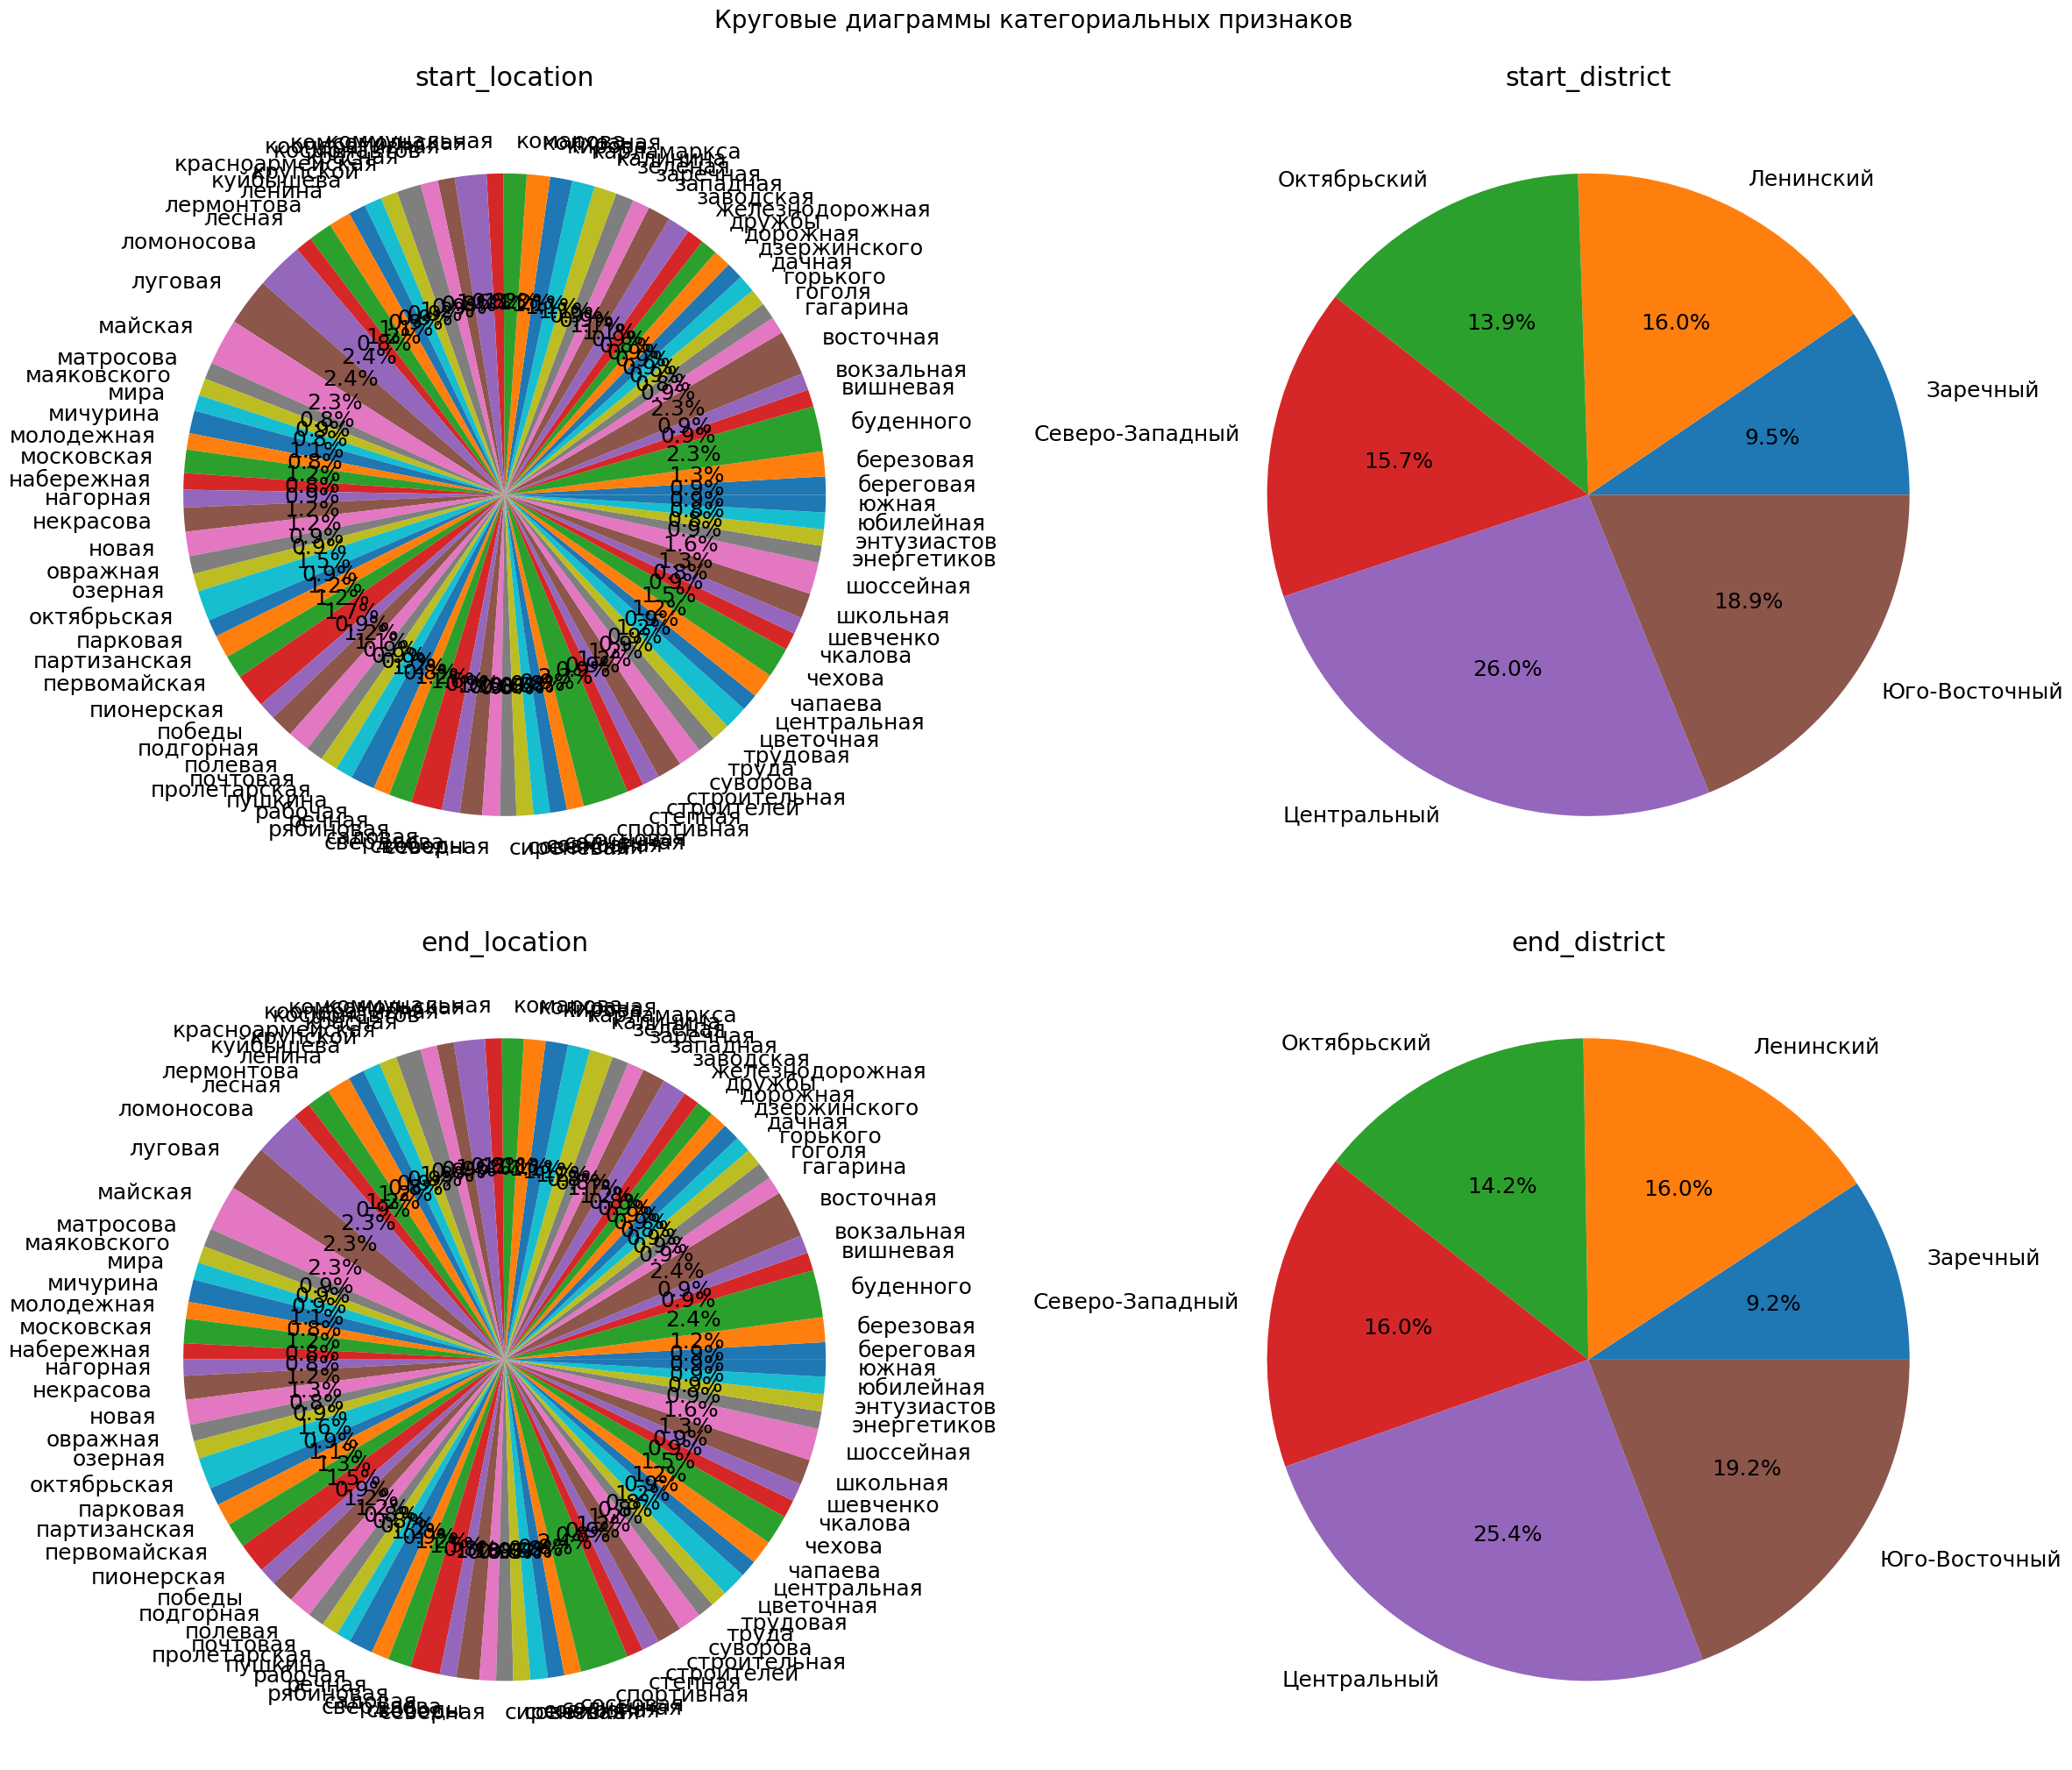

In [38]:
cat_graph(df_main, df_main.select_dtypes(include=[object]).columns)

### 3.3 Проверка работы с данными

#### 3.1 Основаня таблица 

In [39]:
# Ещё раз применим функцию первичноо осмотра данных
check_data(df_main)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Index: 92611 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              92611 non-null  int64         
 1   start_date      92611 non-null  datetime64[ns]
 2   end_date        92611 non-null  datetime64[ns]
 3   start_location  92611 non-null  object        
 4   start_district  92611 non-null  object        
 5   end_location    92611 non-null  object        
 6   end_district    92611 non-null  object        
 7   distance        92611 non-null  float64       
 8   promo           92611 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 7.1+ MB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты


Количество полных дубликатов:  0

Первые пять строк датасета


id          start_date            end_date start_location  \
0   100340 2023-04-22 09:01:00 2023-04-22 09:24:00       шевченко   
1   100341 2023-04-22 09:01:00 2023-04-22 09:29:00         чехова   
2   100342 2023-04-22 09:04:00 2023-04-22 09:42:00      буденного   
3   100343 2023-04-22 09:06:00 2023-04-22 09:38:00          труда   
4   100344 2023-04-22 09:09:00 2023-04-22 09:40:00   первомайская   
5   100345 2023-04-22 09:10:00 2023-04-22 09:49:00         лесная   
6   100346 2023-04-22 09:15:00 2023-04-22 09:26:00   пролетарская   
7   100347 2023-04-22 09:19:00 2023-04-22 09:40:00       комарова   
9   100349 2023-04-22 09:28:00 2023-04-22 10:02:00        свободы   
10  100350 2023-04-22 09:37:00 2023-04-22 09:52:00   коммунальная   

     start_district end_location     end_district  distance  promo  
0     Юго-Восточный      майская      Октябрьский    4069.0      0  
1          Заречный   спортивная      Октябрьский    4515.0      0  
2       Октябрьский     суворова        Ленинский    4520.0      0  
3       Центральный      рабочая  Северо-Западный    3881.0      0  
4   Северо-Западный    юбилейная    Юго-Восточный    4029.0      0  
5     Юго-Восточный     западная        Ленинский    4879.0      0  
6       Центральный      свободы        Ленинский    1846.0      0  
7         Ленинский     западная        Ленинский    3133.0      0  
9         Ленинский      чкалова    Юго-Восточный    5263.0      0  
10    Юго-Восточный   строителей      Центральный    2731.0      0


Описание количественных данных:


count                           mean                  min  \
id          92611.0                  149049.120234             100340.0   
start_date    92611  2023-06-13 21:39:52.406301184  2023-04-22 09:01:00   
end_date      92611  2023-06-13 22:05:48.801546240  2023-04-22 09:24:00   
distance    92611.0                    3780.493506                969.0   
promo       92611.0                       0.019771                  0.0   

                            25%                  50%                  75%  \
id                     124683.5             149064.0             173384.5   
start_date  2023-05-20 21:42:00  2023-06-14 16:02:00  2023-07-08 19:57:00   
end_date    2023-05-20 22:08:30  2023-06-14 16:28:00  2023-07-08 20:23:00   
distance                 3098.0               3718.0               4410.0   
promo                       0.0                  0.0                  0.0   

                            max           std  
id                     197711.0  28114.505524  
start_date  2023-07-31 23:57:00           NaN  
end_date    2023-08-01 00:42:00           NaN  
distance                 6512.0    959.564389  
promo                       1.0      0.139213


Описание категориальных данных:


count unique          top   freq
start_location  92611     91   ломоносова   2207
start_district  92611      6  Центральный  24082
end_location    92611     91   спортивная   2232
end_district    92611      6  Центральный  23520


Вывод уникальных значений по каждому категориаьному признаку:
_start_location


start_location
ломоносова     2207
луговая        2205
майская        2161
спортивная     2112
буденного      2104
               ... 
набережная      768
молодежная      761
энтузиастов     760
сиреневая       754
мира            743
Name: count, Length: 91, dtype: int64

_start_district


start_district
Центральный        24082
Юго-Восточный      17471
Ленинский          14825
Северо-Западный    14538
Октябрьский        12889
Заречный            8806
Name: count, dtype: int64

_end_location


end_location
спортивная         2232
восточная          2196
буденного          2195
ломоносова         2176
луговая            2164
                   ... 
дачная              758
железнодорожная     757
куйбышева           753
набережная          745
пушкина             680
Name: count, Length: 91, dtype: int64

_end_district


end_district
Центральный        23520
Юго-Восточный      17780
Ленинский          14828
Северо-Западный    14815
Октябрьский        13115
Заречный            8553
Name: count, dtype: int64

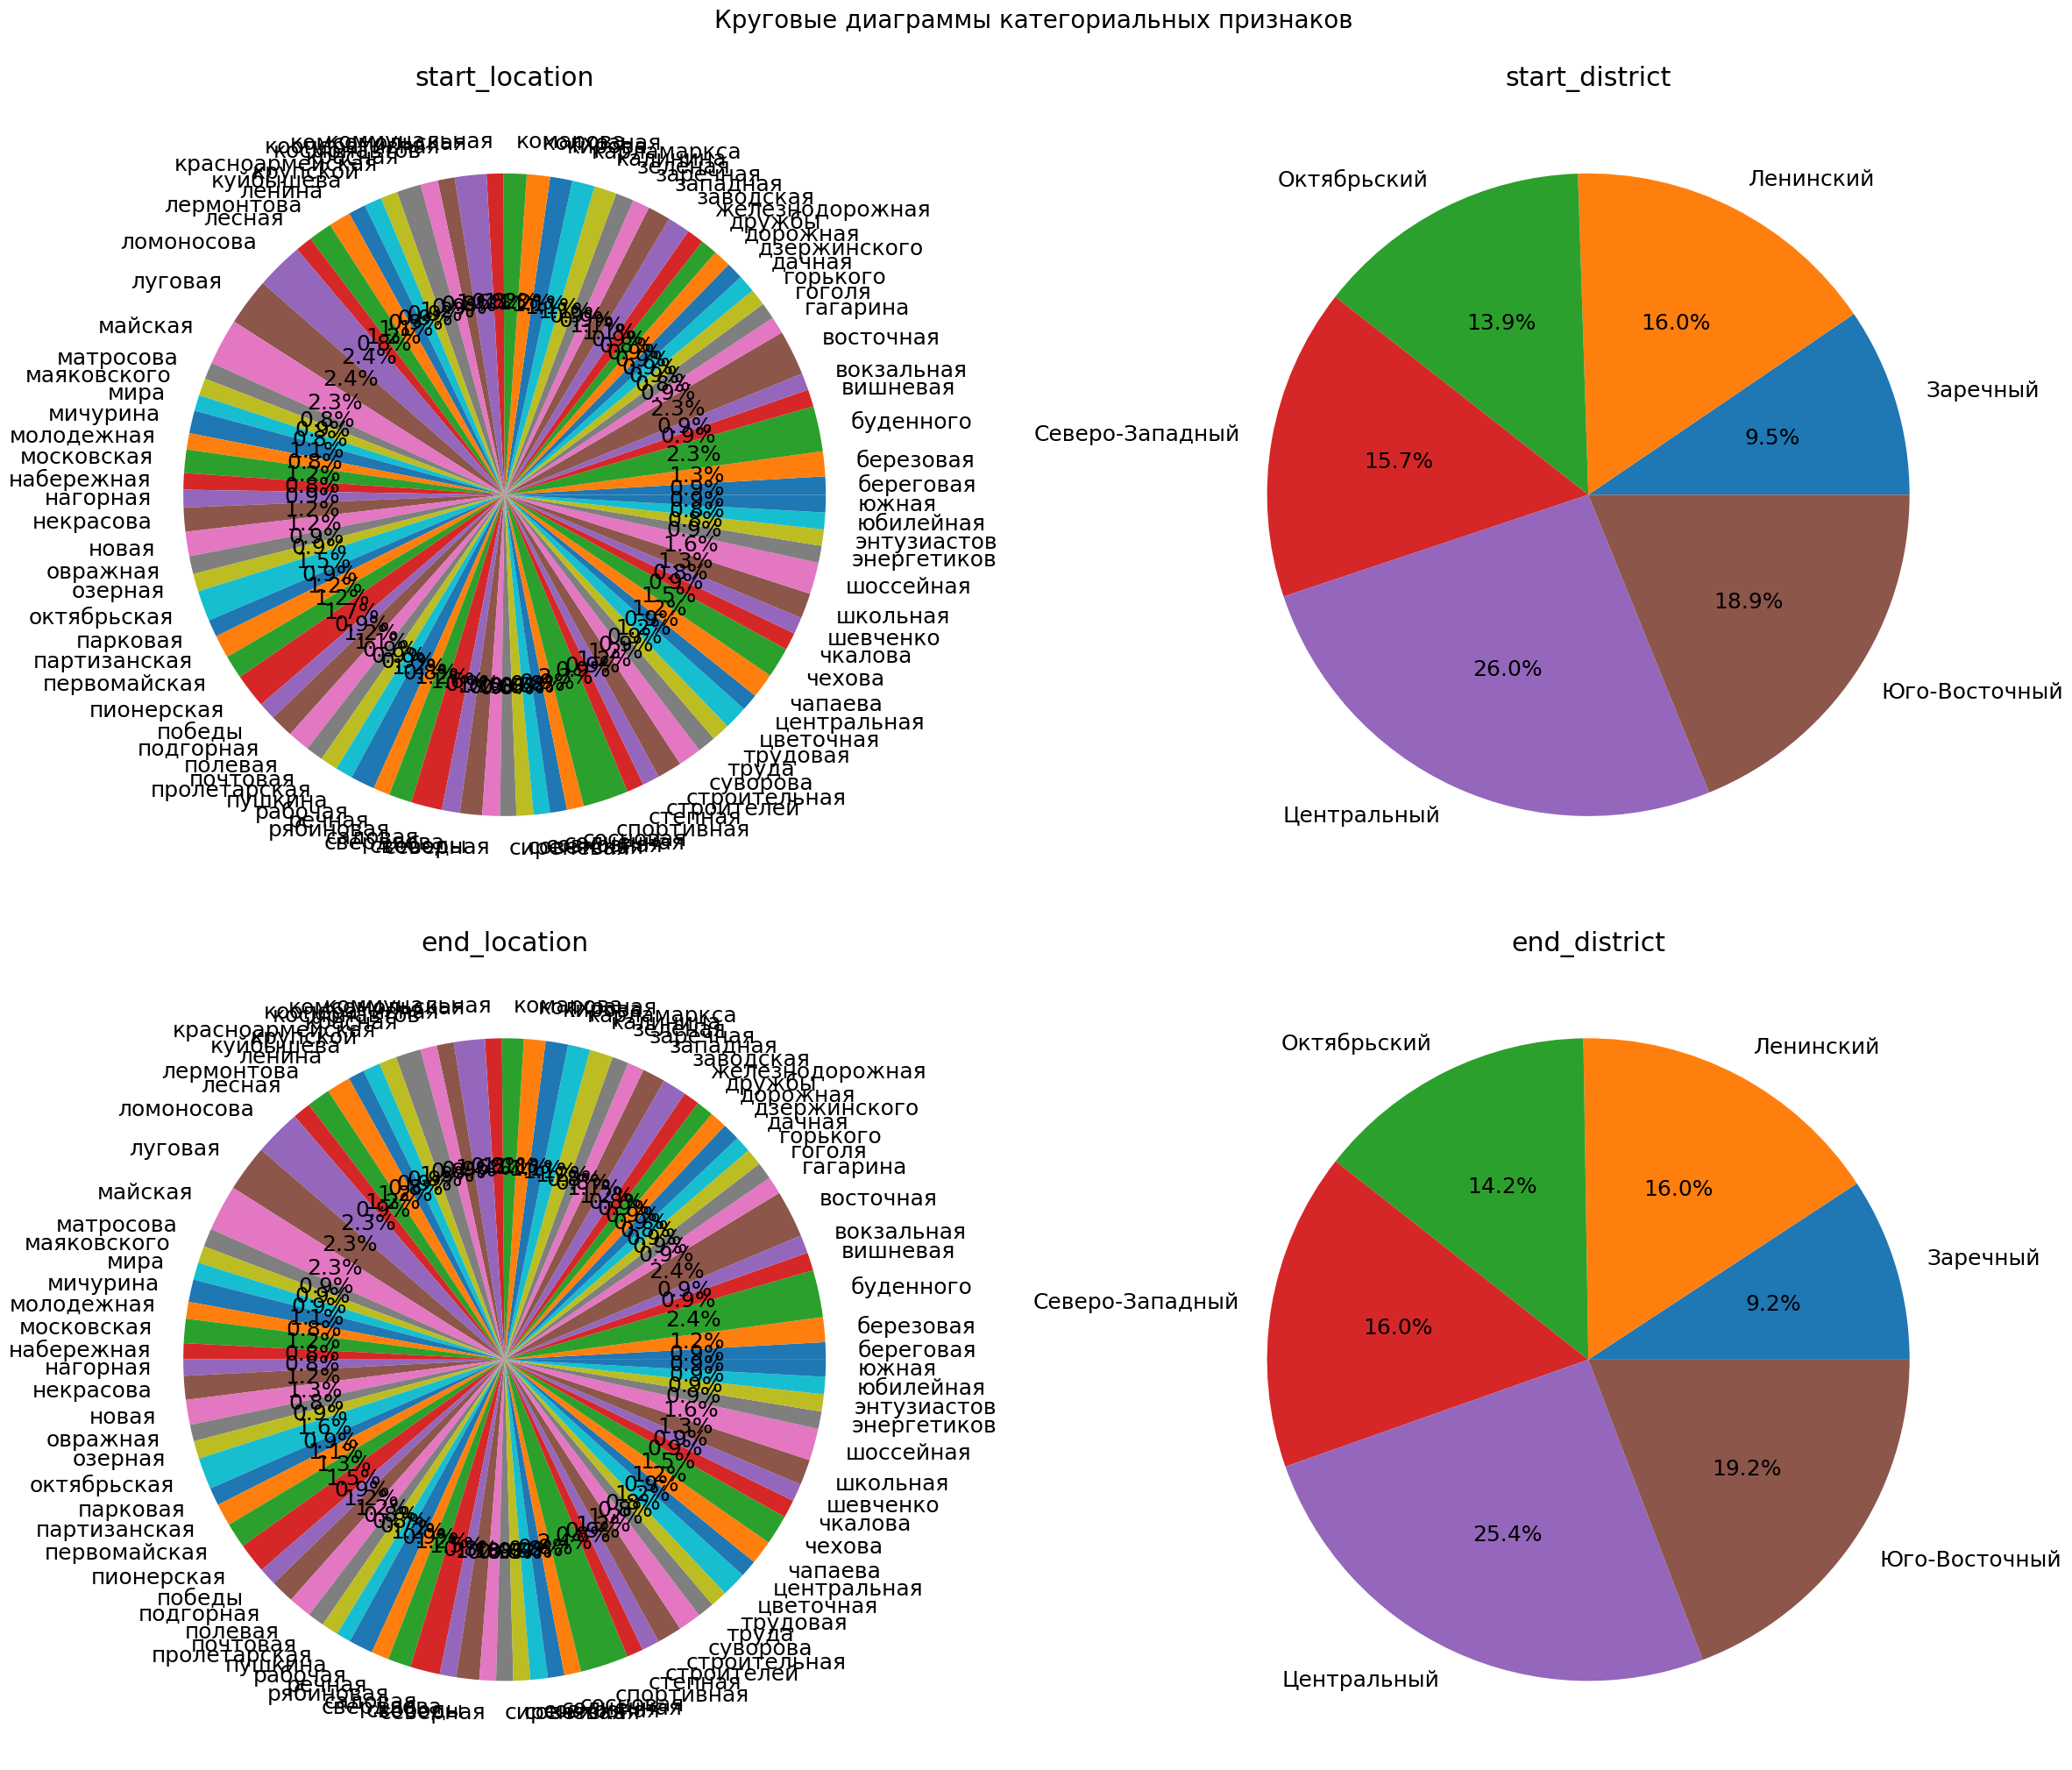

In [40]:
cat_graph(df_main, df_main.select_dtypes(include=[object]).columns)

Выводы по работе с данными

#### 3.2 Таблица с погодой

In [41]:
# Ещё раз применим функцию первичноо осмотра данных
check_data(df_weather)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3673 entries, NaT to 2023-08-31 23:00:00
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   temperature          3618 non-null   object
 1   precipitation_total  3643 non-null   object
 2   wind_gust            3673 non-null   object
 3   wind_speed           3657 non-null   object
 4   cloud_cover_total    3653 non-null   object
 5   sunshine_duration    3661 non-null   object
dtypes: object(6)
memory usage: 200.9+ KB
None

Проверка пропусков
Количество пропусков: 133
Доля пропусков: 0.7%
Доля строк содержащих пропуски: 3.6%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


temperature precipitation_total  wind_gust wind_speed  \
datetime                                                                    
NaT                          °C                  mm       km/h       km/h   
2023-04-01 00:00:00    8.740245                 0.1       48.6  21.638964   
2023-04-01 01:00:00    9.040245                 0.2      55.44  22.493519   
2023-04-01 02:00:00    8.880245                 0.3       55.8   22.26477   
2023-04-01 03:00:00    8.690246                 0.3      55.44   21.94524   
2023-04-01 04:00:00    8.630245                 0.3      48.96   22.42427   
2023-04-01 05:00:00    8.430245                 0.5       48.6   22.91026   
2023-04-01 06:00:00    8.690246                 0.3  50.039997    23.1774   
2023-04-01 07:00:00    8.860246                 0.4      52.56  23.166216   
2023-04-01 08:00:00    8.640245                 0.5         63  20.371038   

                    cloud_cover_total sunshine_duration  
datetime                                                 
NaT                                 %               min  
2023-04-01 00:00:00                90                 0  
2023-04-01 01:00:00                74                 0  
2023-04-01 02:00:00                72                 0  
2023-04-01 03:00:00                77                 0  
2023-04-01 04:00:00                78                 0  
2023-04-01 05:00:00                77                 0  
2023-04-01 06:00:00                98         0.5287884  
2023-04-01 07:00:00                89          6.060605  
2023-04-01 08:00:00                92          4.242425


Описание количественных данных:


count unique         top  freq
temperature          3618   1964   27.540245     9
precipitation_total  3643     36           0  2966
wind_gust            3673    163  11.5199995    86
wind_speed           3657    709   4.3349743    36
cloud_cover_total    3653    197           0   251
sunshine_duration    3661    495           0  1309


Описание категориальных данных:


count unique         top  freq
temperature          3618   1964   27.540245     9
precipitation_total  3643     36           0  2966
wind_gust            3673    163  11.5199995    86
wind_speed           3657    709   4.3349743    36
cloud_cover_total    3653    197           0   251
sunshine_duration    3661    495           0  1309


Вывод уникальных значений по каждому категориаьному признаку:
_temperature


temperature
27.540245    9
15.040245    8
25.610245    8
11.250245    7
15.130245    6
            ..
14.130245    1
12.330245    1
13.260245    1
14.000245    1
19.980246    1
Name: count, Length: 1964, dtype: int64

_precipitation_total


precipitation_total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
       ... 
3         1
5         1
5.8       1
2.9       1
2.7       1
Name: count, Length: 36, dtype: int64

_wind_gust


wind_gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
3.2399998      1
2.8799999      1
60.479996      1
59.76          1
58.679996      1
Name: count, Length: 163, dtype: int64

_wind_speed


wind_speed
4.3349743     36
5.3517847     34
6.28713       33
3.319036      33
4.1046314     32
              ..
15.2947035     1
9.9571085      1
16.981165      1
16.563911      1
19.64228       1
Name: count, Length: 709, dtype: int64

_cloud_cover_total


cloud_cover_total
0            251
100           97
1             56
98            48
20            45
            ... 
69.400002      1
79.7           1
66.400002      1
5.1000004      1
%              1
Name: count, Length: 197, dtype: int64

_sunshine_duration


sunshine_duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
6.729798        1
6.280404        1
6.886363        1
1.3969697       1
1.4999998       1
Name: count, Length: 495, dtype: int64

# 4. Проведение расчётов и иследований

#### 4.1 Рассчёт итоговой стоимости поездки с учетом применения промокода на бесплатный старт.

In [42]:
def get_num_of_day_on_week(date):
    import datetime
    zero_date = datetime.datetime(2023, 4, 22)
    delta_date = date - zero_date
    delta_days = delta_date.days + 5
    num_of_day = delta_days % 7
    # print(date, num_of_day)
    return num_of_day


def get_cost_of_minute(date):
    num_of_day = get_num_of_day_on_week(date)
    price = 0
    if 0 <= num_of_day <= 4:
        if 1 <= date.hour < 6:
            price = 3
        elif 6 <= date.hour < 10:
            price = 4
        elif 10 <= date.hour < 16:
            price = 5
        elif 16 <= date.hour < 22:
            price = 6
        elif 22 <= date.hour or date.hour < 1:
            price = 5
    else:
        if 1 <= date.hour < 6:
            price = 3
        elif 6 <= date.hour < 10:
            price = 4
        elif 10 <= date.hour < 16:
            price = 6
        elif 16 <= date.hour < 22:
            price = 7
        elif 22 <= date.hour or date.hour < 1:
            price = 6
    return price


def get_price(start_time, end_time, promo_used):
    price = get_cost_of_minute(start_time)
    minutes = (end_time - start_time).seconds // 60
    return (promo_used + 1) % 2 * 30 + minutes * price

In [43]:
df_main['cost'] = df_main.apply(lambda row: get_price(row['start_date'], row['end_date'], row['promo']), axis=1)

C:\Users\Master\AppData\Local\Temp\ipykernel_19556\3435550929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['cost'] = df_main.apply(lambda row: get_price(row['start_date'], row['end_date'], row['promo']), axis=1)


In [44]:
# Смотрим на результат.
df_main.head(10)

id          start_date            end_date start_location  \
0   100340 2023-04-22 09:01:00 2023-04-22 09:24:00       шевченко   
1   100341 2023-04-22 09:01:00 2023-04-22 09:29:00         чехова   
2   100342 2023-04-22 09:04:00 2023-04-22 09:42:00      буденного   
3   100343 2023-04-22 09:06:00 2023-04-22 09:38:00          труда   
4   100344 2023-04-22 09:09:00 2023-04-22 09:40:00   первомайская   
5   100345 2023-04-22 09:10:00 2023-04-22 09:49:00         лесная   
6   100346 2023-04-22 09:15:00 2023-04-22 09:26:00   пролетарская   
7   100347 2023-04-22 09:19:00 2023-04-22 09:40:00       комарова   
9   100349 2023-04-22 09:28:00 2023-04-22 10:02:00        свободы   
10  100350 2023-04-22 09:37:00 2023-04-22 09:52:00   коммунальная   

     start_district end_location     end_district  distance  promo  cost  
0     Юго-Восточный      майская      Октябрьский    4069.0      0   122  
1          Заречный   спортивная      Октябрьский    4515.0      0   142  
2       Октябрьский     суворова        Ленинский    4520.0      0   182  
3       Центральный      рабочая  Северо-Западный    3881.0      0   158  
4   Северо-Западный    юбилейная    Юго-Восточный    4029.0      0   154  
5     Юго-Восточный     западная        Ленинский    4879.0      0   186  
6       Центральный      свободы        Ленинский    1846.0      0    74  
7         Ленинский     западная        Ленинский    3133.0      0   114  
9         Ленинский      чкалова    Юго-Восточный    5263.0      0   166  
10    Юго-Восточный   строителей      Центральный    2731.0      0    90

#### 4.2 Проверяем, стимулирует ли акция с бесплатным стартом по понедельникам спрос насамокаты. Окупается ли она.

In [45]:
# demand scooter - спрос на самокаты (почасовой)
dem_scoot = df_main[['start_date', 'promo', 'cost']]
dem_scoot['frequency'] = 1
dem_scoot = dem_scoot.resample('1h', on='start_date').agg({'promo':'sum', 'cost': 'sum', 'frequency': 'count'})
dem_scoot.reset_index(inplace=True)
dem_scoot.head(3)

C:\Users\Master\AppData\Local\Temp\ipykernel_19556\3803689153.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem_scoot['frequency'] = 1


start_date  promo  cost  frequency
0 2023-04-22 09:00:00      0  2618         19
1 2023-04-22 10:00:00      0  7350         41
2 2023-04-22 11:00:00      0  4914         27

In [46]:
# По понедельникам с 6:00 до 10:00 акция «Бесплатный старт» по промокоду.
dem_scoot_promo_time = dem_scoot[(6 <= dem_scoot['start_date'].dt.hour) 
                                 & (dem_scoot['start_date'].dt.hour <= 9)]
dem_scoot_promo_time = dem_scoot_promo_time.resample('1d', on='start_date').agg({'promo':'sum', 'cost': 'sum', 'frequency': 'sum'})
dem_scoot_promo_time.reset_index(inplace=True)
# В dem_scoot_promo_time хранится информация о спросе по дням во временное окно акции
dem_scoot_promo_time.head(3)

start_date  promo   cost  frequency
0 2023-04-22      0   2618         19
1 2023-04-23      0  10374         73
2 2023-04-24     60  11300        100

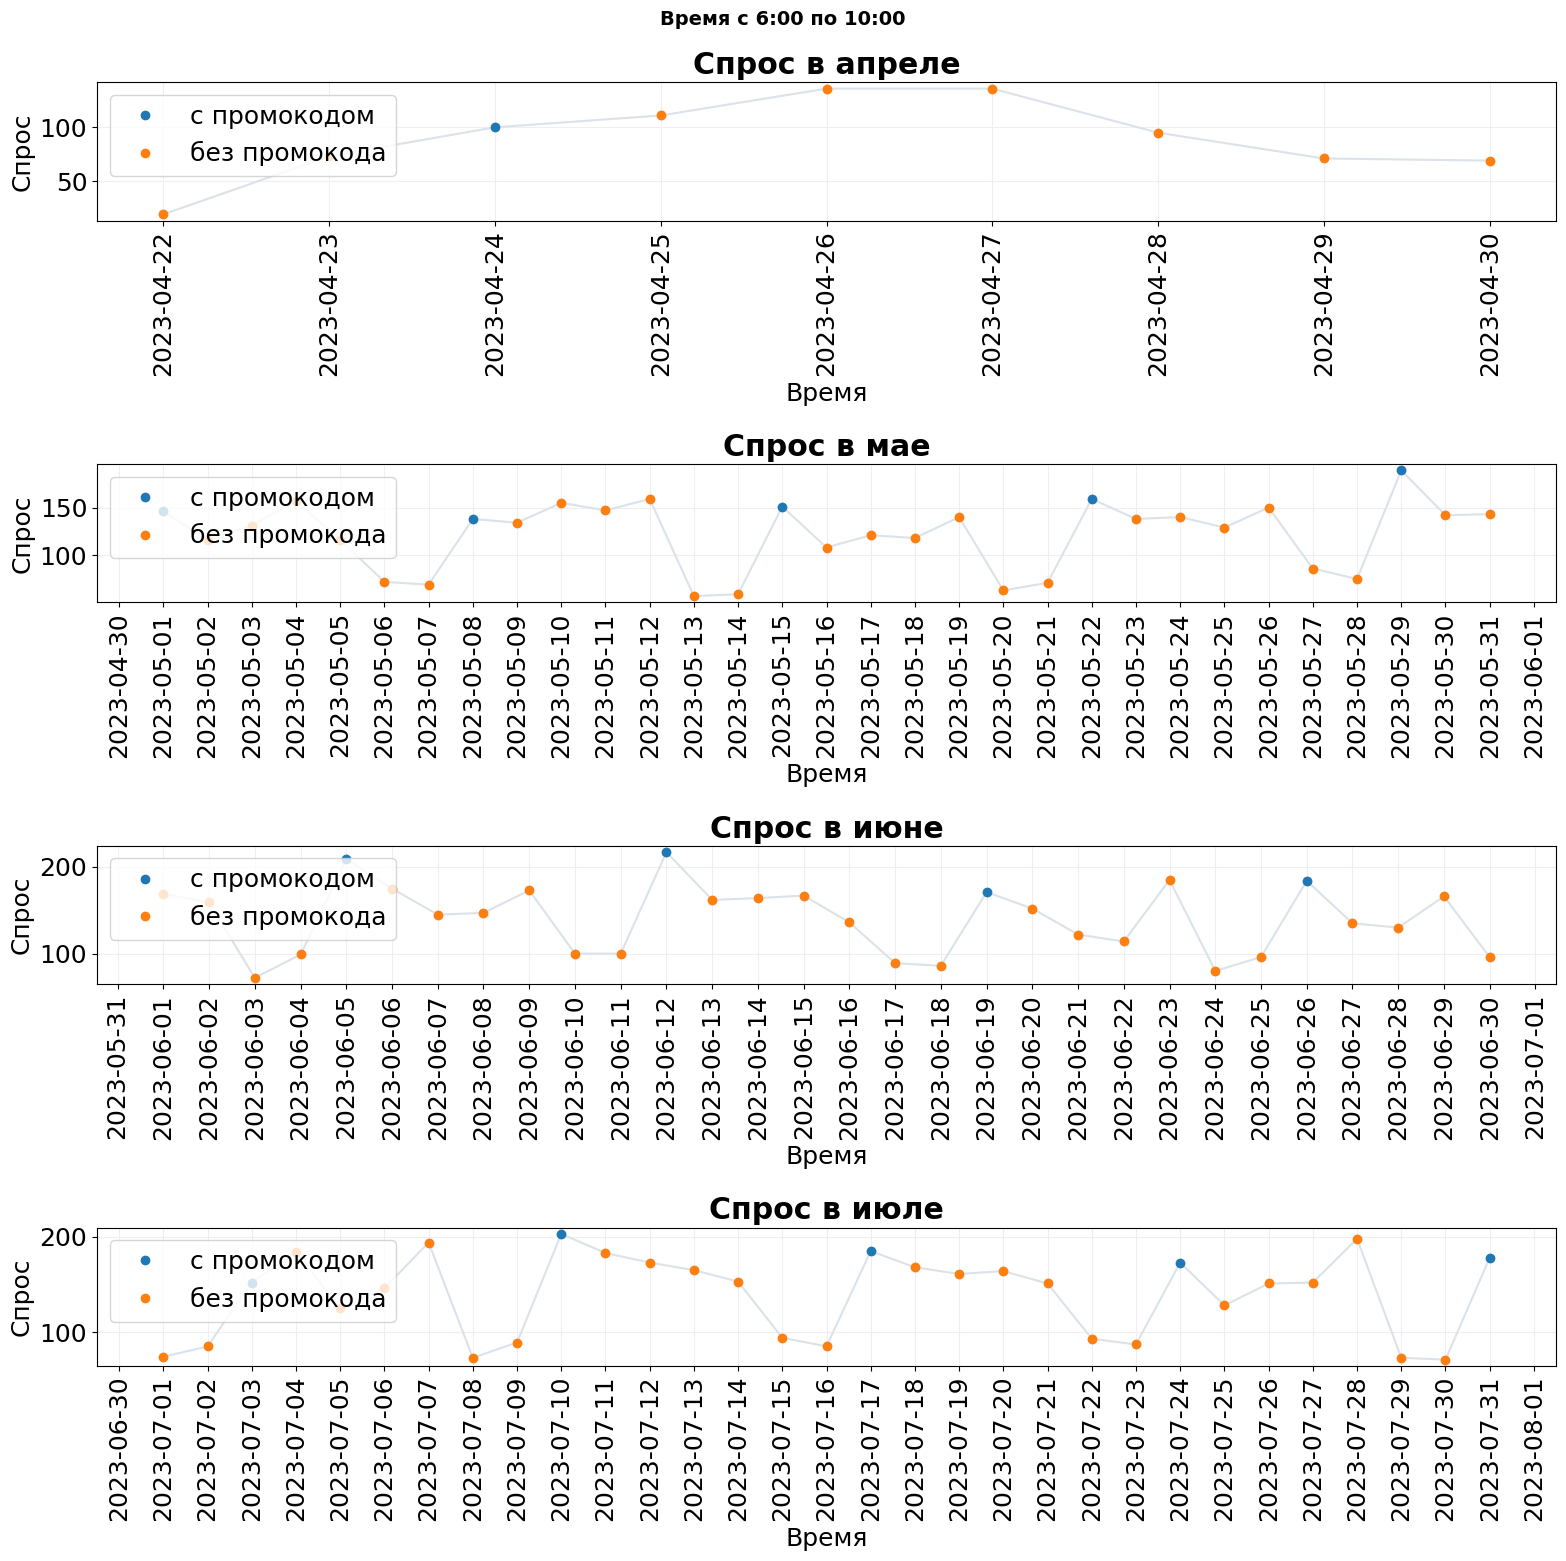

In [47]:
monthes_translate = {4: 'апреле',
                     5: 'мае',
                     6: 'июне',
                     7: 'июле'}
monthes = dem_scoot_promo_time['start_date'].dt.month.unique()

fig, axs = plt.subplots(nrows=len(monthes), figsize=(16, 16))
fig.suptitle('Время с 6:00 по 10:00', fontweight='bold', fontsize=14)

for i, m in enumerate(monthes):
    dem_scoot_data = dem_scoot_promo_time[(dem_scoot_promo_time['start_date'].dt.month == m)]

    x_values = dem_scoot_data['start_date']
    y_values = dem_scoot_data['frequency']

    dates = matplotlib.dates.date2num(x_values)

    axs[i].plot_date(dates, y_values, color='#DBE2E9', linestyle='-')

    promo_rides = dem_scoot_data[dem_scoot_data['promo'] > 0]

    x_values = promo_rides['start_date']
    y_values = promo_rides['frequency']

    dates = matplotlib.dates.date2num(x_values)
    axs[i].plot_date(dates, y_values, label='с промокодом')
    

    no_promo_rides = dem_scoot_data[dem_scoot_data['promo'] == 0]

    x_values = no_promo_rides['start_date']
    y_values = no_promo_rides['frequency']

    dates = matplotlib.dates.date2num(x_values)
    axs[i].plot_date(dates, y_values, label='без промокода')

    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].legend(loc="upper left")
    axs[i].set_xlabel('Время')
    axs[i].set_ylabel('Спрос')
    axs[i].set_title(f'Спрос в {monthes_translate[m]}', fontweight='bold')
    axs[i].grid(color='#F1EDF2')
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
fig.tight_layout()

**Вывод акция с промокодом**

#### 4.3 Исследование корреляции между параметрами погодных условий.

#### 4.4 Таблица с почасовым спросом на самокаты.

In [48]:
# demand scooter - спрос на самокаты (почасовой)
dem_scoot.head(5)

start_date  promo  cost  frequency
0 2023-04-22 09:00:00      0  2618         19
1 2023-04-22 10:00:00      0  7350         41
2 2023-04-22 11:00:00      0  4914         27
3 2023-04-22 12:00:00      0  7572         41
4 2023-04-22 13:00:00      0  8172         46

#### 4.5 Определяем необходимое количесво самокатов в каждой точке и в каждом районе.

In [49]:
# locations это list всевозможных локаций(точек)
locations = set(df_main['start_location'].unique())
locations = locations.union(set(df_main['start_location'].unique()))
locations = list(locations)

In [50]:
'''
Будем считать что каждый день в 6:00 на точках появляется необходимое количество самокатов,
иначе будет накапливаться минус в точках где откуда самокаты чаще уезжают(/ШУТКА: Завода производящего самокаты там нет/)

Время 6:00 выбрано потому что предполагаем что в этот час начинается движение, запускается цикл спроса 
(работники, студенты, ... направляются в свои учреждения)
'''
locations_traffic = dict()

for location in locations:
    df_start = df_main[df_main['start_location'] == location][['start_date', 'cost']]
    df_start['traffic'] = 1
    df_start.columns = ['date', 'cost', 'traffic']

    df_end = df_main[df_main['end_location'] == location][['end_date', 'cost']]
    df_end['traffic'] = -1
    df_end.columns = ['date', 'cost', 'traffic']
    df_location = pd.concat([df_start, df_end], ignore_index=True)
    df_location = df_location.sort_values(by='date')
    # df_location = df_location.resample('1h', on='date').agg({'traffic': 'sum'}).reset_index()
    df_location['traffic_cum'] = df_location.resample('d', on='date')['traffic'].cumsum()
    df_location['traffic_cum_cont'] = df_location['traffic'].cumsum()
    locations_traffic[location] = df_location
df_location.head(3)

date  cost  traffic  traffic_cum  traffic_cum_cont
1063 2023-04-22 09:40:00   114       -1           -1                -1
1062 2023-04-22 09:49:00   186       -1           -2                -2
0    2023-04-22 13:30:00   210        1           -1                -1

In [51]:
'''
Предполагаю что количество необходимых самокатов в точках зависит от дня недели.
Поэтому считаю минимум по траффику самокатов в каждой точке по каждому дню отдельно,
также считаю минимум за все время и среднее за все время по минимумам по дням недели в точке.

Минимальное будет браться среди отрицательных чисел, 
так как нам важно понять сколько самокатов необходимо для того чтобы каждый смог воспользоваться услугой.
Человек не может воспользоваться услугой когда число самокатов в точке отрицательно(нет самокатов).
'''
df_locations_minuse_traffic_stat = pd.DataFrame({'location': [], 
                                 'mean_min_at_1d': [], 
                                 'min_at_all_time_1d': [],
                                 'mean_min_at_2d': [], 
                                 'min_at_all_time_2d': [],
                                 'mean_min_at_3d': [], 
                                 'min_at_all_time_3d': [],
                                 'mean_min_at_4d': [], 
                                 'min_at_all_time_4d': [],
                                 'mean_min_at_5d': [], 
                                 'min_at_all_time_5d': [],
                                 'mean_min_at_6d': [], 
                                 'min_at_all_time_6d': [],
                                 'mean_min_at_7d': [], 
                                 'min_at_all_time_7d': [],
                                 'mean_min_at_all_time': [],
                                 'min_at_all_time': []})

'''
Посмотрим на количество самокатов которое остается в конце дня
'''
df_locations_remains_stat = pd.DataFrame({'location': [], 
                                 'mean_at_1d': [], 
                                 'max_at_all_time_1d': [],
                                 'mean_at_2d': [], 
                                 'max_at_all_time_2d': [],
                                 'mean_at_3d': [], 
                                 'max_at_all_time_3d': [],
                                 'mean_at_4d': [], 
                                 'max_at_all_time_4d': [],
                                 'mean_at_5d': [], 
                                 'max_at_all_time_5d': [],
                                 'mean_at_6d': [], 
                                 'max_at_all_time_6d': [],
                                 'mean_at_7d': [], 
                                 'max_at_all_time_7d': [],
                                 'mean_at_all_time': [],
                                 'max_at_all_time': []})

for location in locations_traffic:
    location_traffic_day = locations_traffic[location].resample('1d', origin='2023-04-01 06:00:00', on='date').agg({'traffic': 'sum', 'traffic_cum': 'min'})
    location_traffic_day.reset_index(inplace=True)
    location_traffic_day['num_day'] = location_traffic_day['date'].apply(get_num_of_day_on_week)

    # Для df_locations_minuse_traffic_stat
    location_stat = [location]
    for day in location_traffic_day['num_day'].unique():
        min_traffics_at_day = location_traffic_day[(location_traffic_day['num_day'] == day)
                                                    & (location_traffic_day['traffic_cum'] < 0)]['traffic_cum']
        mean_min_at_day = min_traffics_at_day.mean()
        min_at_all_time = min_traffics_at_day.min()
        location_stat.extend([mean_min_at_day, min_at_all_time])
    location_stat.append(location_traffic_day[location_traffic_day['traffic_cum'] < 0]['traffic_cum'].mean())
    location_stat.append(location_traffic_day[location_traffic_day['traffic_cum'] < 0]['traffic_cum'].min())
    df_locations_minuse_traffic_stat.loc[len(df_locations_minuse_traffic_stat)] = location_stat

    # Для df_locations_remains_stat
    location_stat = [location]
    for day in location_traffic_day['num_day'].unique():
        min_traffics_at_day = location_traffic_day[location_traffic_day['num_day'] == day]['traffic']
        mean_min_at_day = min_traffics_at_day.mean()
        min_at_all_time = min_traffics_at_day.max()
        location_stat.extend([mean_min_at_day, min_at_all_time])
    location_stat.append(location_traffic_day['traffic'].mean())
    location_stat.append(location_traffic_day['traffic'].max())
    df_locations_remains_stat.loc[len(df_locations_remains_stat)] = location_stat


df_locations_minuse_traffic_stat = df_locations_minuse_traffic_stat.fillna(0)
cols = df_locations_minuse_traffic_stat.columns.to_list()
cols.pop(0)
for col in cols:
    df_locations_minuse_traffic_stat[col] = df_locations_minuse_traffic_stat[col].astype(int)
df_locations_minuse_traffic_stat.sort_values(by='min_at_all_time', inplace=True)

df_locations_remains_stat = df_locations_remains_stat.fillna(0)
cols = df_locations_remains_stat.columns.to_list()
cols.pop(0)
for col in cols:
    df_locations_remains_stat[col] = df_locations_remains_stat[col].astype(int)
df_locations_remains_stat.sort_values(by='mean_at_all_time', inplace=True)

In [52]:
df_locations_minuse_traffic_stat.head(3)

location  mean_min_at_1d  min_at_all_time_1d  mean_min_at_2d  \
29   ломоносова              -6                 -18              -4   
66  центральная              -3                 -19              -4   
84   спортивная              -7                 -19              -4   

    min_at_all_time_2d  mean_min_at_3d  min_at_all_time_3d  mean_min_at_4d  \
29                 -15              -5                 -16              -5   
66                 -10              -2                  -6              -2   
84                 -13              -4                 -11              -5   

    min_at_all_time_4d  mean_min_at_5d  min_at_all_time_5d  mean_min_at_6d  \
29                 -21              -4                 -13              -3   
66                  -6              -3                 -11              -2   
84                 -14              -4                 -11              -4   

    min_at_all_time_6d  mean_min_at_7d  min_at_all_time_7d  \
29                 -11              -4                 -13   
66                  -8              -3                 -10   
84                 -10              -5                 -13   

    mean_min_at_all_time  min_at_all_time  
29                    -4              -21  
66                    -3              -19  
84                    -5              -19

In [53]:
df_locations_remains_stat.head(3)

location  mean_at_1d  max_at_all_time_1d  mean_at_2d  \
84   спортивная          -3                   5           2   
0       чкалова           0                   8           0   
65  космонавтов           0                   6           1   

    max_at_all_time_2d  mean_at_3d  max_at_all_time_3d  mean_at_4d  \
84                  15          -1                   6          -1   
0                    7           0                   5           1   
65                   8           0                   9           0   

    max_at_all_time_4d  mean_at_5d  max_at_all_time_5d  mean_at_6d  \
84                  13           0                   7          -1   
0                    8           0                   5          -1   
65                   6           0                   7           1   

    max_at_all_time_6d  mean_at_7d  max_at_all_time_7d  mean_at_all_time  \
84                   6          -1                  10                -1   
0                    7           0                   6                 0   
65                   8           0                   6                 0   

    max_at_all_time  
84               15  
0                 8  
65                9

In [54]:
'''
В датафрейме информация о том сколько самокатов должно быть в точке утром в 6:00 для того чтобы полностью удовлетворить спрос
'''
df_necessary_quantity_scoots = df_locations_minuse_traffic_stat[['location', 'min_at_all_time']]
df_necessary_quantity_scoots.loc[:, 'min_at_all_time'] = df_necessary_quantity_scoots['min_at_all_time'].abs()
df_necessary_quantity_scoots.columns = ['location', 'necessary_quantity']
df_necessary_quantity_scoots = df_necessary_quantity_scoots.reset_index().drop('index', axis=1)
df_necessary_quantity_scoots.head(3)

location  necessary_quantity
0   ломоносова                  21
1  центральная                  19
2   спортивная                  19

In [55]:
''' 
Попытка анализировать трафик в точках по наличию тренда,
строю регресию и сортирую точки по углу полученой линии 

'''
def is_trand(data):
    x = np.arange(0, len(data))
    y = np.array(data)

    z = np.polyfit(x, y, 1)
    return z[0], z[1]


df_loc_traf_cum_cont = pd.DataFrame({'location': [], 'traffic_cum_cont': [], 'mean_traffic_cum_cont': [], 'reg_tg': [], 'reg_b': []})
for location in locations:
    df_location_traffic = locations_traffic[location]

    res = is_trand(df_location_traffic['traffic_cum_cont'])
    df_loc_traf_cum_cont.loc[len(df_loc_traf_cum_cont)] = [location, 
                                                           df_location_traffic.loc[len(df_location_traffic) - 1, 'traffic_cum_cont'],
                                                           df_location_traffic['traffic_cum_cont'].mean(),
                                                           res[0],
                                                           res[1]]
x_ = 100
df_loc_traf_cum_cont['reg_dec'] = df_loc_traf_cum_cont['reg_tg'] * x_**2 + df_loc_traf_cum_cont['reg_b'] + x_
df_loc_traf_cum_cont.sort_values(by='reg_dec', inplace=True)
df_loc_traf_cum_cont.head(3)

location  traffic_cum_cont  mean_traffic_cum_cont    reg_tg      reg_b  \
57       мира               -65             -52.999355 -0.053293 -11.697415   
64   шевченко               -40             -51.187811 -0.046786 -13.595200   
81  цветочная               -64             -10.308137 -0.048600  44.318676   

       reg_dec  
57 -444.625676  
64 -381.455947  
81 -341.684994

' \nНиже график trafic_1\n'

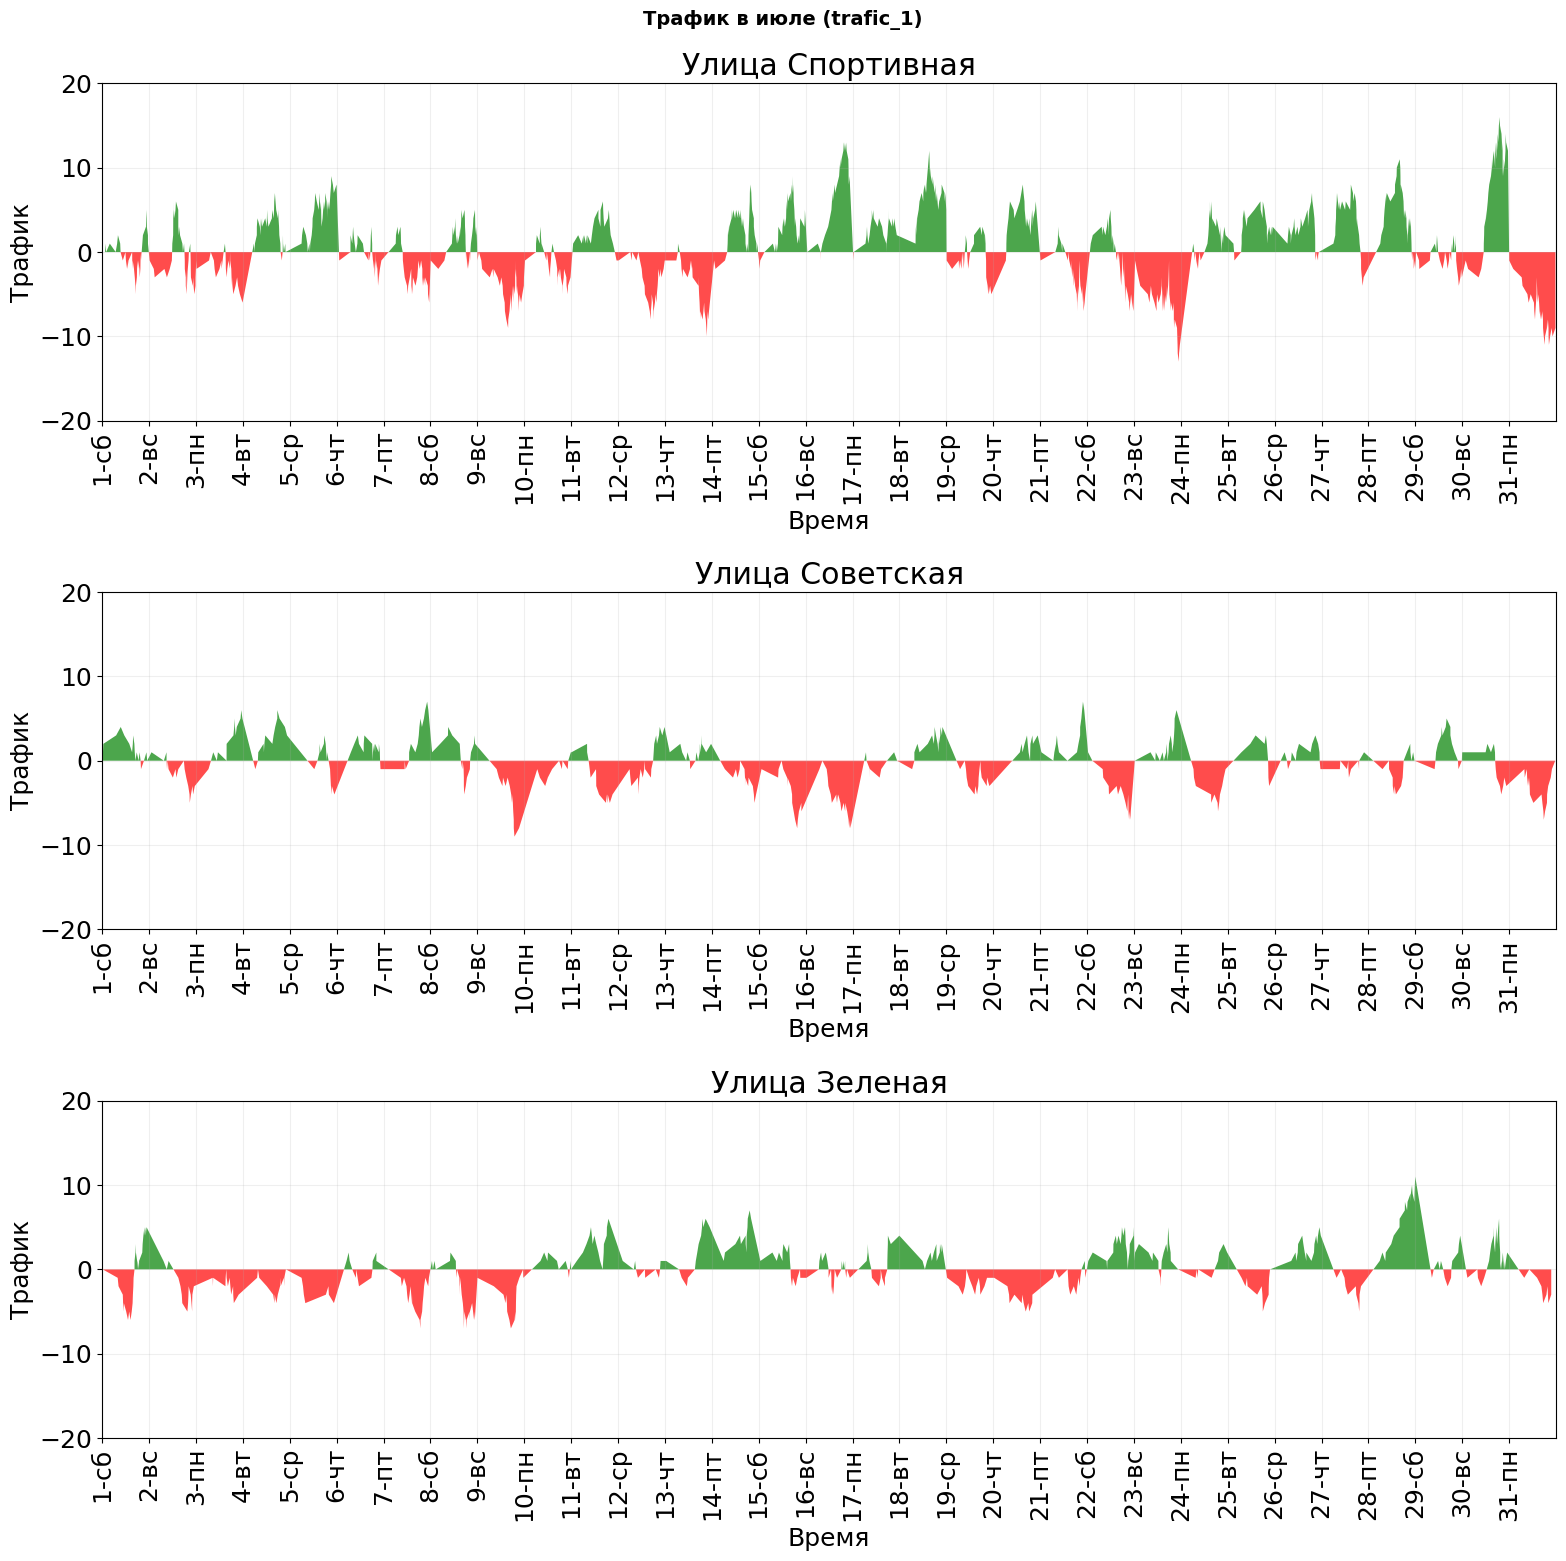

In [56]:
name_num_day = {
    0: 'пн',
    1: 'вт',
    2: 'ср',
    3: 'чт',
    4: 'пт',
    5: 'сб',
    6: 'вс'
}


month = 7
fig, axs = plt.subplots(nrows=3, figsize=(16, 16))
fig.suptitle(f'Трафик в {monthes_translate[month]} (trafic_1)', fontweight='bold', fontsize=14)

for i, location in enumerate(['спортивная', 'советская', 'зеленая']):
    df_location = locations_traffic[location]

    x = df_location[df_location['date'].dt.month == month]['date']
    y_returns = df_location[df_location['date'].dt.month == month]['traffic_cum']


    axs[i].fill_between(x, y_returns, 0, where=y_returns >= 0, facecolor='green', interpolate=True, alpha=0.7)
    axs[i].fill_between(x, y_returns, 0, where=y_returns <= 0, facecolor='red', interpolate=True, alpha=0.7)

    days = x.reset_index().set_index('date').resample('d').sum().reset_index().drop('index', axis=1)['date']
    xtickvals = [str(date.date().day) + "-" + name_num_day[get_num_of_day_on_week(date)] for date in days]
    

    axs[i].grid(alpha=0.2)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    axs[i].set_xticks(days)
    axs[i].set_xlim(days.iloc[0], days.iloc[len(days) - 1] + timedelta(days=1))
    axs[i].set_ylim(-20, 20)

    axs[i].set_xticklabels(xtickvals, rotation=90)
    
    axs[i].set_xlabel('Время')
    axs[i].set_ylabel('Трафик')
    axs[i].set_title(f'Улица {location.capitalize()}')

fig.tight_layout()
''' 
Ниже график trafic_1
'''

' \nНиже график trafic_2\n'

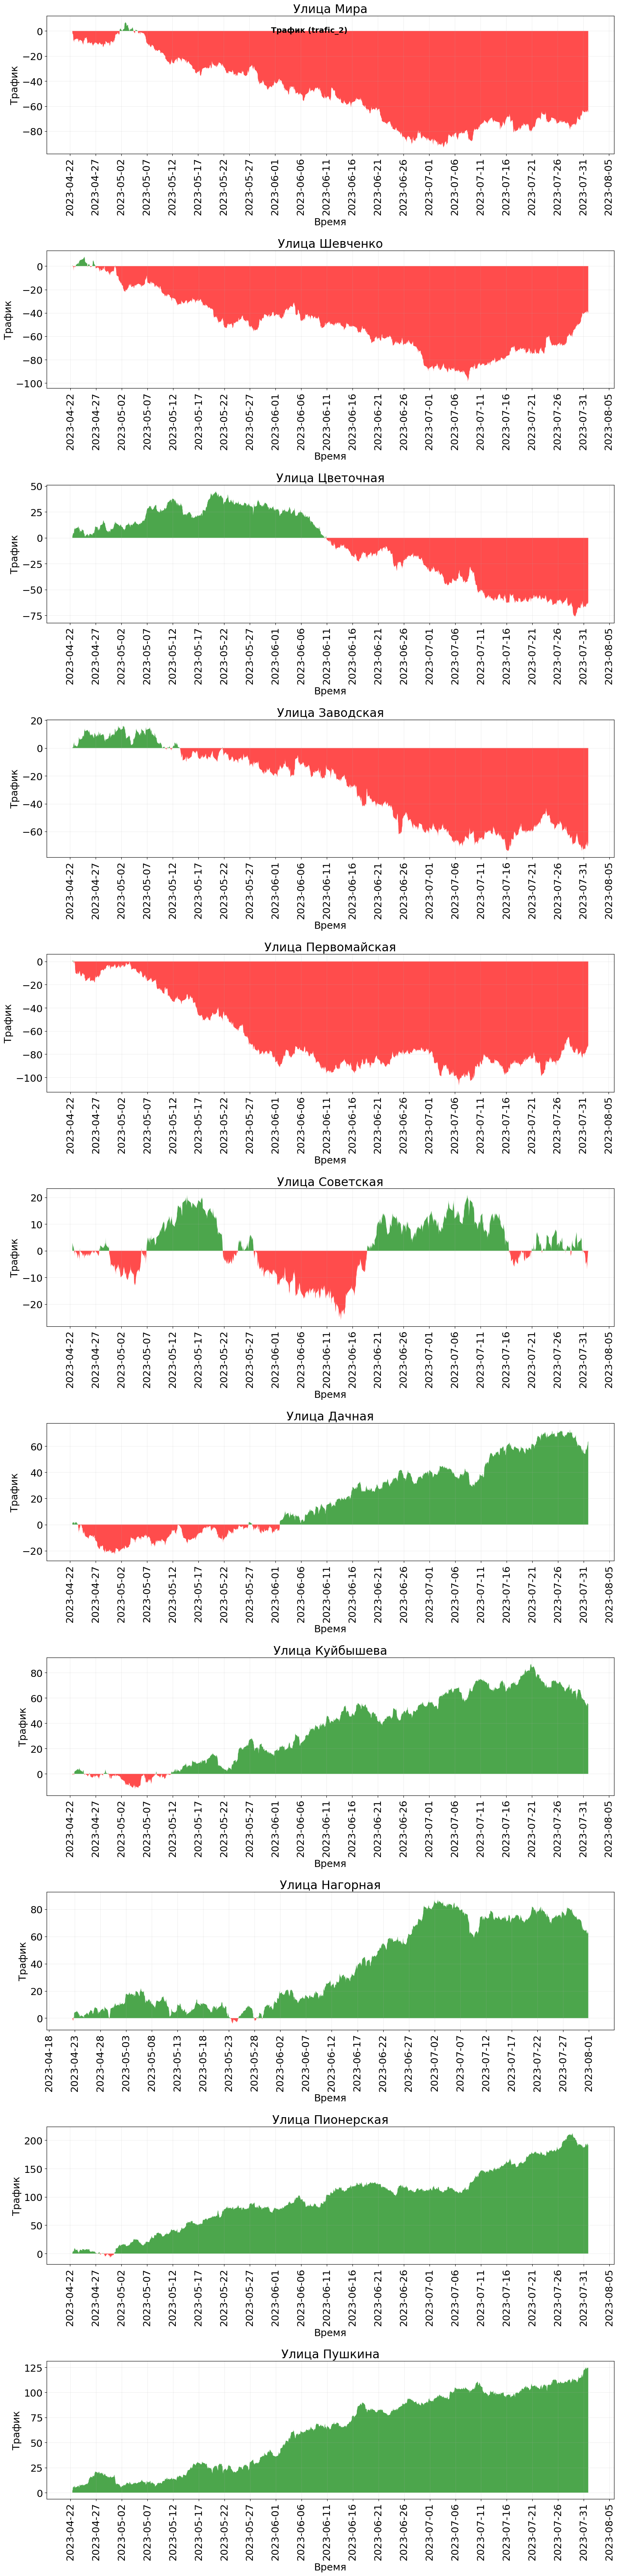

In [57]:
name_num_day = {
    0: 'пн',
    1: 'вт',
    2: 'ср',
    3: 'чт',
    4: 'пт',
    5: 'сб',
    6: 'вс'
}

# streets = ['спортивная', 'советская', 'зеленая']
streets = df_loc_traf_cum_cont['location'].to_list()[:5] + ['советская'] + df_loc_traf_cum_cont['location'].to_list()[-5:]
fig, axs = plt.subplots(nrows=len(streets), figsize=(16, 6 * len(streets)))
fig.suptitle('Трафик (trafic_2)', fontweight='bold', fontsize=14)

for i, location in enumerate(streets):
    df_location = locations_traffic[location]

    x = df_location['date']
    y_returns = df_location['traffic'].cumsum()


    axs[i].fill_between(x, y_returns, 0, where=y_returns >= 0, facecolor='green', alpha=0.7)
    axs[i].fill_between(x, y_returns, 0, where=y_returns <= 0, facecolor='red', alpha=0.7)

    

    axs[i].grid(alpha=0.2)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=5))

    
    axs[i].set_xlabel('Время')
    axs[i].set_ylabel('Трафик')
    axs[i].set_title(f'Улица {location.capitalize()}')
    axs[i].tick_params(axis='x', labelrotation=90)

fig.tight_layout()
''' 
Ниже график trafic_2
'''

In [58]:
''' 
Для графиков были взяты топ-5 улиц сверху и снизу остсортированного датафрейма df_loc_traf_cum_cont
Датафрейм df_loc_traf_cum_cont был отсортирован по возрастанию площади под линией регрессии построенной по трафику
Сделано это было для того чтобы определить точки с возраст./убыв. трендом количества самокатов 
Далее были выведены графики для проверки соответствия
Улица 'советская' добавлена в качестве премера той улицы, которую не стоит использовать для балансировки.
'''

" \nДля графиков были взяты топ-5 улиц сверху и снизу остсортированного датафрейма df_loc_traf_cum_cont\nДатафрейм df_loc_traf_cum_cont был отсортирован по возрастанию площади под линией регрессии построенной по трафику\nСделано это было для того чтобы определить точки с возраст./убыв. трендом количества самокатов \nДалее были выведены графики для проверки соответствия\nУлица 'советская' добавлена в качестве премера той улицы, которую не стоит использовать для балансировки.\n"

In [59]:
streets


['мира',
 'шевченко',
 'цветочная',
 'заводская',
 'первомайская',
 'советская',
 'дачная',
 'куйбышева',
 'нагорная',
 'пионерская',
 'пушкина']

In [60]:
''' 
Из датафрэйма df_locations_remains_stat отсортированного по возрастанию среднего по оставшимся самокатам в 6:00
Видно что самокаты в целом в конце дня если и остаются то в малом количестве, что делает не выгодным их транспортировку в другие точки,
а также из датафрэйма df_necessary_quantity_scoots видно что во все точки необходимо поставлять самокаты чтобы покрыть спрос
Получается что перераспредилить самокаты в конце дня не получится.
Возможно для перераспределения самокатов нужно выбирать разное время для каждой точки, тогда удасться покрыть спрос, так как в некоторые точки самокаты чаще приехжают,
а из других уезжают (например: 'спортивная', 'зеленая') -> Это видно из графика trafic_2 на улицу 'зеленая' чаще приезжают, поэтому если самокаты от туда не увозить,
то они будут копиться, к примеру их можно увозить на улицу 'спортивная'.

Но сказать что стабильно можно перенаправлять самокаты в конце дня с какой то улицы не получается, потому что есть много минимумов, которые видно из графика,
и предугадать когда можно увезти получится только при более детальном исследованиии и при отслеживании самокатов online

Пока что кажется что по этим данным решить задачу балансировки самокатов offline не получится.
Но можно сказать примерно из каких точек в какие можно перенаправить.
Для этого обратимся к графику выше.
По проведённому исследованию предлагаю делать балансировку самокатов из ['куйбышева', 'дачная', 'пионерская', 'нагорная', 'пушкина']
в ['мира', 'шевченко', 'заводская', 'матросова', 'вокзальная']

'''

" \nИз датафрэйма df_locations_remains_stat отсортированного по возрастанию среднего по оставшимся самокатам в 6:00\nВидно что самокаты в целом в конце дня если и остаются то в малом количестве, что делает не выгодным их транспортировку в другие точки,\nа также из датафрэйма df_necessary_quantity_scoots видно что во все точки необходимо поставлять самокаты чтобы покрыть спрос\nПолучается что перераспредилить самокаты в конце дня не получится.\nВозможно для перераспределения самокатов нужно выбирать разное время для каждой точки, тогда удасться покрыть спрос, так как в некоторые точки самокаты чаще приехжают,\nа из других уезжают (например: 'спортивная', 'зеленая') -> Это видно из графика trafic_2 на улицу 'зеленая' чаще приезжают, поэтому если самокаты от туда не увозить,\nто они будут копиться, к примеру их можно увозить на улицу 'спортивная'.\n\nНо сказать что стабильно можно перенаправлять самокаты в конце дня с какой то улицы не получается, потому что есть много минимумов, которые 

#### 4.6 Определим Топ-3 точки с самым высоким трафиком

In [61]:
from scipy.stats import shapiro
''' 
Определим точки с самым высоким трафиком
За трафик буду считать количество самокатов которое приезжает/уезжает из точки в час времени (кол-во/час)

Считаю что в расчёт нужно брать все часы, так как ночью у некоторых точек может повышаться спрос.
Если брать все часы, то среднее будет меньше чем если бы мы брали среднее лишь по дню, так как много часов простоя,
но это справедливо для всех точек.
'''
location_demand_h = dict()
df_location_mean_demand = pd.DataFrame({'location': [], 
                                        'mean_demand_h': [], 
                                        'mean_demand_d': [], 
                                        'median_demand_d': [], 
                                        'shapiro_pvalue': [],
                                        'mean_cum_cost_h': [],
                                        'cost_all_time': []})
for location in locations:
    df_location = locations_traffic[location].drop('traffic_cum', axis=1)
    df_location.loc[:, 'traffic'] = df_location['traffic'].abs()
    df_location_d = df_location.resample('1d', on='date').sum()
    df_location = df_location.resample('1h', on='date').sum()
    location_demand_h[location] = df_location
    df_location_mean_demand.loc[len(df_location_mean_demand)] = [location, 
                                                                 df_location['traffic'].mean(), 
                                                                 df_location_d['traffic'].mean(),
                                                                 df_location_d['traffic'].median(),
                                                                 round(shapiro(df_location['traffic']).pvalue, 4),
                                                                 df_location['cost'].mean(),
                                                                 df_location['cost'].sum()
                                                                 ]

df_location_mean_demand = df_location_mean_demand.sort_values(by='mean_demand_h', key=lambda x: -x).reset_index().drop('index', axis=1)
df_location_mean_demand.join(df_necessary_quantity_scoots.set_index('location'), on='location')
df_location_mean_demand

location  mean_demand_h  mean_demand_d  median_demand_d  shapiro_pvalue  \
0   ломоносова       1.816411      43.396040             42.0             0.0   
1      луговая       1.809859      43.257426             42.0             0.0   
2   спортивная       1.798758      43.009901             42.0             0.0   
3      майская       1.786661      42.702970             42.0             0.0   
4    буденного       1.780862      42.564356             41.0             0.0   
..         ...            ...            ...              ...             ...   
86        мира       0.642768      15.205882             15.0             0.0   
87   сиреневая       0.640845      15.316832             15.0             0.0   
88  молодежная       0.639039      15.267327             15.0             0.0   
89  набережная       0.627020      14.980198             15.0             0.0   
90     пушкина       0.615927      14.702970             15.0             0.0   

    mean_cum_cost_h  cost_all_time  
0        311.796933         752366  
1        310.664043         749943  
2        306.998344         741401  
3        304.551781         735188  
4        303.777962         733320  
..              ...            ...  
86       108.496477         261802  
87       116.002486         280030  
88       114.048487         275199  
89       106.406548         256759  
90       104.342182         251569  

[91 rows x 7 columns]

In [62]:
''' 
Из таблицы видно что среднее ~ соответствует медиане, а также shapiro стремится к 0 (распред нормальное, можно судить по среднему)
'''

' \nИз таблицы видно что среднее ~ соответствует медиане, а также shapiro стремится к 0 (распред нормальное, можно судить по среднему)\n'

In [63]:
''''
Топ-3 точки с самым высоким трафиком
'''
df_location_mean_demand.loc[:2]

location  mean_demand_h  mean_demand_d  median_demand_d  shapiro_pvalue  \
0  ломоносова       1.816411      43.396040             42.0             0.0   
1     луговая       1.809859      43.257426             42.0             0.0   
2  спортивная       1.798758      43.009901             42.0             0.0   

   mean_cum_cost_h  cost_all_time  
0       311.796933         752366  
1       310.664043         749943  
2       306.998344         741401

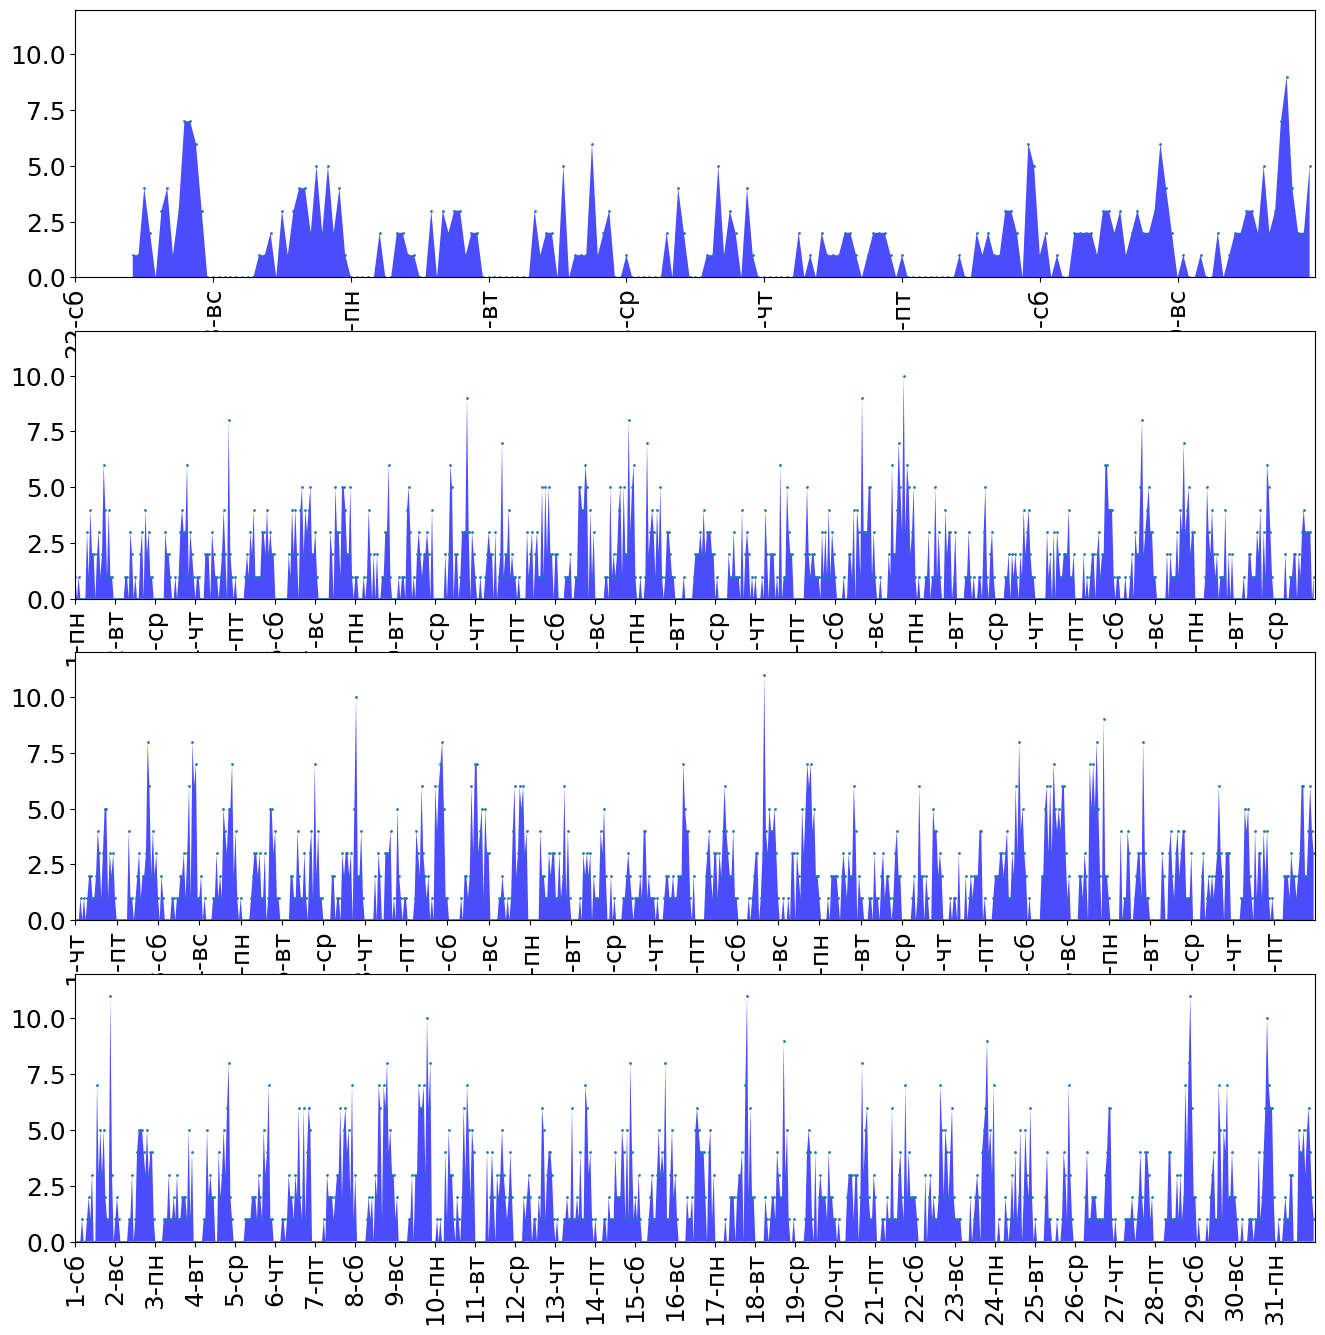

In [64]:
'луговая'
df_location_demand_h = location_demand_h['луговая']
monthes = df_location_demand_h.index.month.unique()
fig, axs = plt.subplots(nrows=len(monthes), figsize=(16, 16))
for i, month in enumerate(monthes[:]):
    df_location_demand_h_m = df_location_demand_h[df_location_demand_h.index.month == month]
    x = df_location_demand_h_m.index
    y = df_location_demand_h_m['traffic']

    axs[i].plot_date(x, y, markersize=1)
    axs[i].fill_between(x, y, 0, facecolor='blue', alpha=0.7)
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

    days = df_location_demand_h_m.resample('d').sum().index
    xtickvals = [str(date.date().day) + "-" + name_num_day[get_num_of_day_on_week(date)] for date in days]

    axs[i].set_xticks(days)
    axs[i].set_xlim(days[0], days[len(days) - 1] + timedelta(days=1))
    axs[i].set_ylim(0, 12)
    axs[i].set_xticklabels(xtickvals, rotation=90)

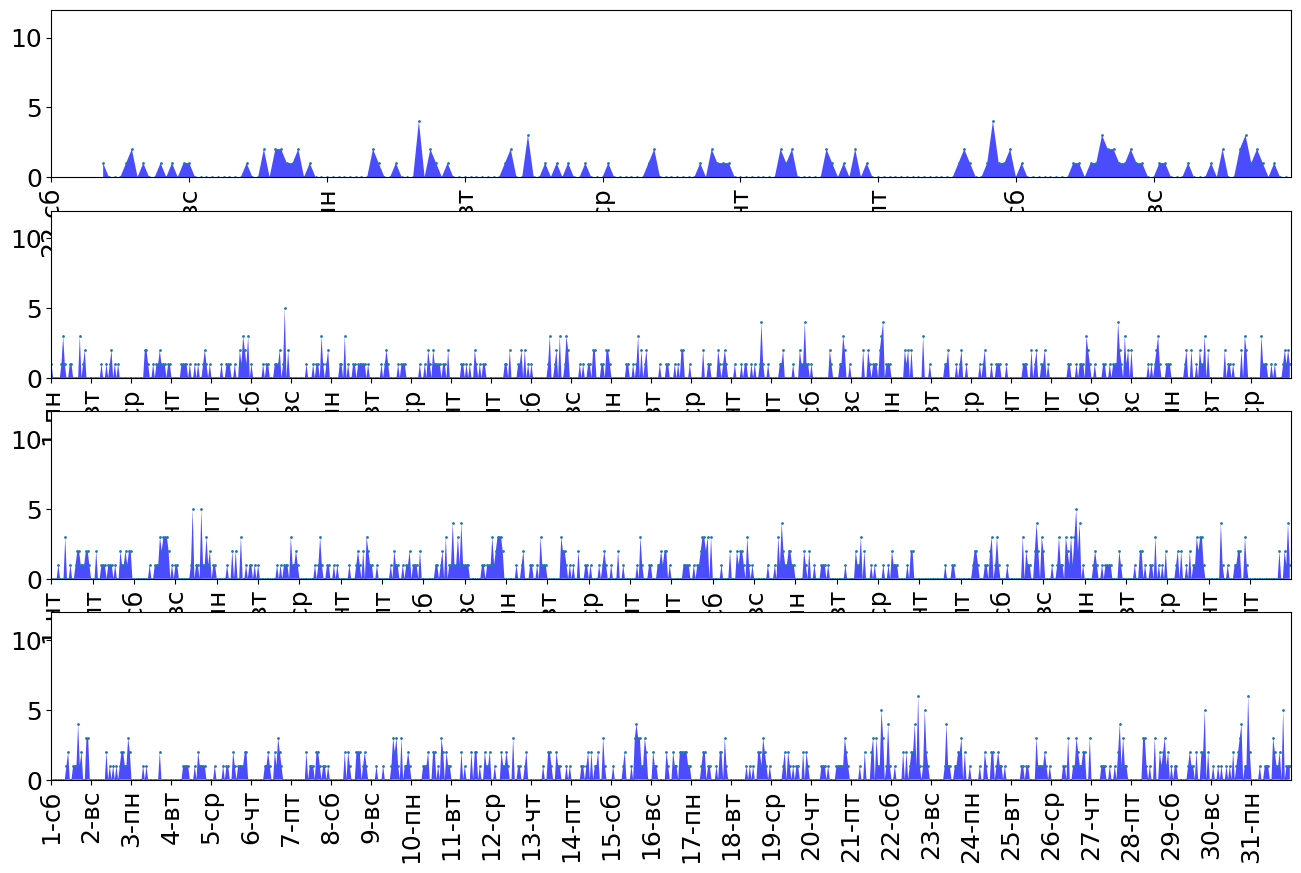

In [65]:
'пушкина'
'''
дзержинского	0.691384
66	северная	0.691128
67	сосновая	0.688484
68	овражная	0.687967
69	зеленая	0.687526
70	пролетарская	0.686413
71	южная	0.686283
72	заречная	0.684932
73	совхозная	0.683513
74	коммунальная	0.683513
75	кооперативная	0.682573
76	нагорная	0.680780
77	молодежная	0.680066
78	дачная	0.679519
79	гоголя	0.679503
80	энтузиастов	0.676337
81	советская	0.674814
82	сиреневая	0.674399
83	железнодорожная	0.672750
84	солнечная	0.670813
85	дружбы	0.669983
86	куйбышева	0.667909
87	мира	0.667634
88	степная	0.660315
89	набережная
'''
df_location_demand_h = location_demand_h['гоголя']
monthes = df_location_demand_h.index.month.unique()
fig, axs = plt.subplots(nrows=4, figsize=(16, 10))
for i, month in enumerate(range(4, 7 + 1)):
    df_location_demand_h_m = df_location_demand_h[df_location_demand_h.index.month == month]
    x = df_location_demand_h_m.index
    y = df_location_demand_h_m['traffic']

    axs[i].plot_date(x, y, markersize=1)
    axs[i].fill_between(x, y, 0, facecolor='blue', alpha=0.7)
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

    days = df_location_demand_h_m.resample('d').sum().index
    xtickvals = [str(date.date().day) + "-" + name_num_day[get_num_of_day_on_week(date)] for date in days]

    axs[i].set_xticks(days)
    axs[i].set_xlim(days[0], days[len(days) - 1] + timedelta(days=1))
    axs[i].set_ylim(0, 12)
    axs[i].set_xticklabels(xtickvals, rotation=90)

In [66]:
''' 
Из графиков точки с самым высоким средним спросом и самым низким можно увидить разницу
'''

' \nИз графиков точки с самым высоким средним спросом и самым низким можно увидить разницу\n'

#### 4.7 Самые популярные направления перемещения

In [67]:
df_directions = pd.DataFrame()
df_directions['direction_location'] = df_main['start_location'] + '->' + df_main['end_location']
df_directions['direction_ditsrict'] = df_main['start_district'] + '->' + df_main['end_district']

In [68]:
df_directions['direction_location'].value_counts().head(10)

direction_location
луговая->спортивная       66
буденного->буденного      65
майская->спортивная       60
спортивная->восточная     58
восточная->луговая        57
спортивная->майская       56
ломоносова->спортивная    55
восточная->ломоносова     55
луговая->луговая          54
майская->буденного        54
Name: count, dtype: int64

In [69]:
df_directions['direction_ditsrict'].value_counts().head(10)

direction_ditsrict
Центральный->Центральный        5817
Центральный->Юго-Восточный      4745
Юго-Восточный->Центральный      4465
Центральный->Северо-Западный    4004
Северо-Западный->Центральный    3826
Центральный->Ленинский          3792
Ленинский->Центральный          3772
Центральный->Октябрьский        3504
Юго-Восточный->Юго-Восточный    3467
Октябрьский->Центральный        3314
Name: count, dtype: int64

In [70]:
'''
direction_location 
direction_district в топе находятся таки направления как 
'''

'\ndirection_location \ndirection_district в топе находятся таки направления как \n'

# 5. Провека гипотез


#### 5.2 Проверка различия средней стоимости поездки по районам

In [71]:
# Группировка данных по районам и вычисление средней стоимости поездки для каждого района
mean_costs_by_district = df_main.groupby('start_district')['cost'].mean()

In [72]:
# Вывод средних значений стоимости поездок по районам
print("Средняя стоимость поездок по районам:")
print(mean_costs_by_district)

Средняя стоимость поездок по районам:
start_district
Заречный           182.454349
Ленинский          174.312648
Октябрьский        170.773916
Северо-Западный    181.524212
Центральный        172.139689
Юго-Восточный      178.919753
Name: cost, dtype: float64


In [73]:
# Проведение однофакторного дисперсионного анализа (ANOVA)
# Получение данных о стоимости поездок для каждого района
costs_by_district = []
for district in df_main['start_district'].unique():
    costs_by_district.append(df_main[df_main['start_district'] == district]['cost'])

# Проведение ANOVA
f_statistic, p_value = f_oneway(*costs_by_district)

# Вывод результатов ANOVA
print("\nРезультаты однофакторного дисперсионного анализа (ANOVA):")
print("F-статистика:", f_statistic)
print("p-значение:", p_value)

# Оценка статистической значимости
alpha = 0.05
if p_value < alpha:
    print("\nОтвергаем нулевую гипотезу: средние значения стоимости поездок по районам различаются.")
else:
    print("\nНе отвергаем нулевую гипотезу: нет статистически значимых различий в средней стоимости поездок по районам.")



Результаты однофакторного дисперсионного анализа (ANOVA):
F-статистика: 82.76836970691298
p-значение: 4.851918405218418e-87

Отвергаем нулевую гипотезу: средние значения стоимости поездок по районам различаются.


**Вывод: Средняя стоимость поездки не отличается по районам**

#### 5.3 Проверка зависимости дня недели от спроса на самокты.

In [74]:
# Добавление столбца для дня недели (0 - 4 будни, 5 - 6  выходные)
df_main['Day of Week'] = df_main['start_date'].dt.dayofweek

C:\Users\Master\AppData\Local\Temp\ipykernel_19556\2211626019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main['Day of Week'] = df_main['start_date'].dt.dayofweek


In [75]:
# Агрегирование данных
daily_demand = df_main.groupby('Day of Week').size()

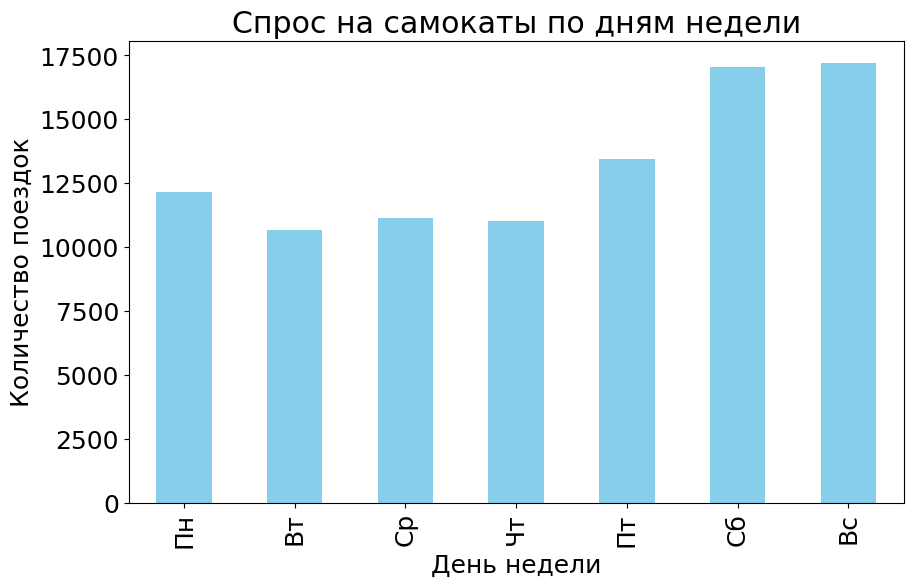

In [76]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
daily_demand.plot(kind='bar', color='skyblue')
plt.title('Спрос на самокаты по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()

**Вывод: Из графика видно, что на спрос влияет день недели. Следоватьельно гипотеза подтвердилась**

#### 5.4 Проверка длительности поездок по выходным и будням

In [77]:
# Разделение данных на будни и выходные
weekday_trips = df_main[df_main['Day of Week'] < 5]
weekend_trips = df_main[df_main['Day of Week'] >= 5]

In [78]:
# Вычисление длительности поездок в минутах
weekday_trips['duration'] = (weekday_trips['end_date'] - weekday_trips['start_date']).dt.total_seconds() / 60
weekend_trips['duration'] = (weekend_trips['end_date'] - weekend_trips['start_date']).dt.total_seconds() / 60

C:\Users\Master\AppData\Local\Temp\ipykernel_19556\2948675747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_trips['duration'] = (weekday_trips['end_date'] - weekday_trips['start_date']).dt.total_seconds() / 60
C:\Users\Master\AppData\Local\Temp\ipykernel_19556\2948675747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_trips['duration'] = (weekend_trips['end_date'] - weekend_trips['start_date']).dt.total_seconds() / 60


In [79]:
# Вывод средних длительностей поездок
print("Средняя длительность поездок по будням:", weekday_trips['duration'].mean(), "минут")
print("Средняя длительность поездок по выходным:", weekend_trips['duration'].mean(), "минут")

Средняя длительность поездок по будням: 25.29892049348869 минут
Средняя длительность поездок по выходным: 27.0321158506321 минут


**Вывод: В среднем поездки по времени одинакоыве, следоватьельно гипотеза опровегнута**

# 6 Регрессионное моделирование

In [146]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [102]:
dem_scoot.head(3)
dem_scoot_index_date = dem_scoot.set_index('start_date')
train, test = train_test_split(dem_scoot_index_date['frequency'], test_size=0.2, shuffle=False)

In [178]:
model = SARIMAX(train, 
                order = (3, 1, 1), 
                seasonal_order = (2, 1, 1, 24))
result = model.fit()

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [179]:
start = test.index[0]
 
# и закончится в конце тестового
end = test.index[-1]
  
# применим метод predict
predictions = result.predict(start, end)
predictions

2023-07-11 21:00:00    42.656963
2023-07-11 22:00:00    29.998553
2023-07-11 23:00:00    11.938070
2023-07-12 00:00:00     0.180592
2023-07-12 01:00:00    -2.971049
                         ...    
2023-07-31 19:00:00    90.882957
2023-07-31 20:00:00    80.593369
2023-07-31 21:00:00    66.906751
2023-07-31 22:00:00    52.489548
2023-07-31 23:00:00    32.132471
Freq: H, Name: predicted_mean, Length: 483, dtype: float64

285.02800955001146
16.882772567028542


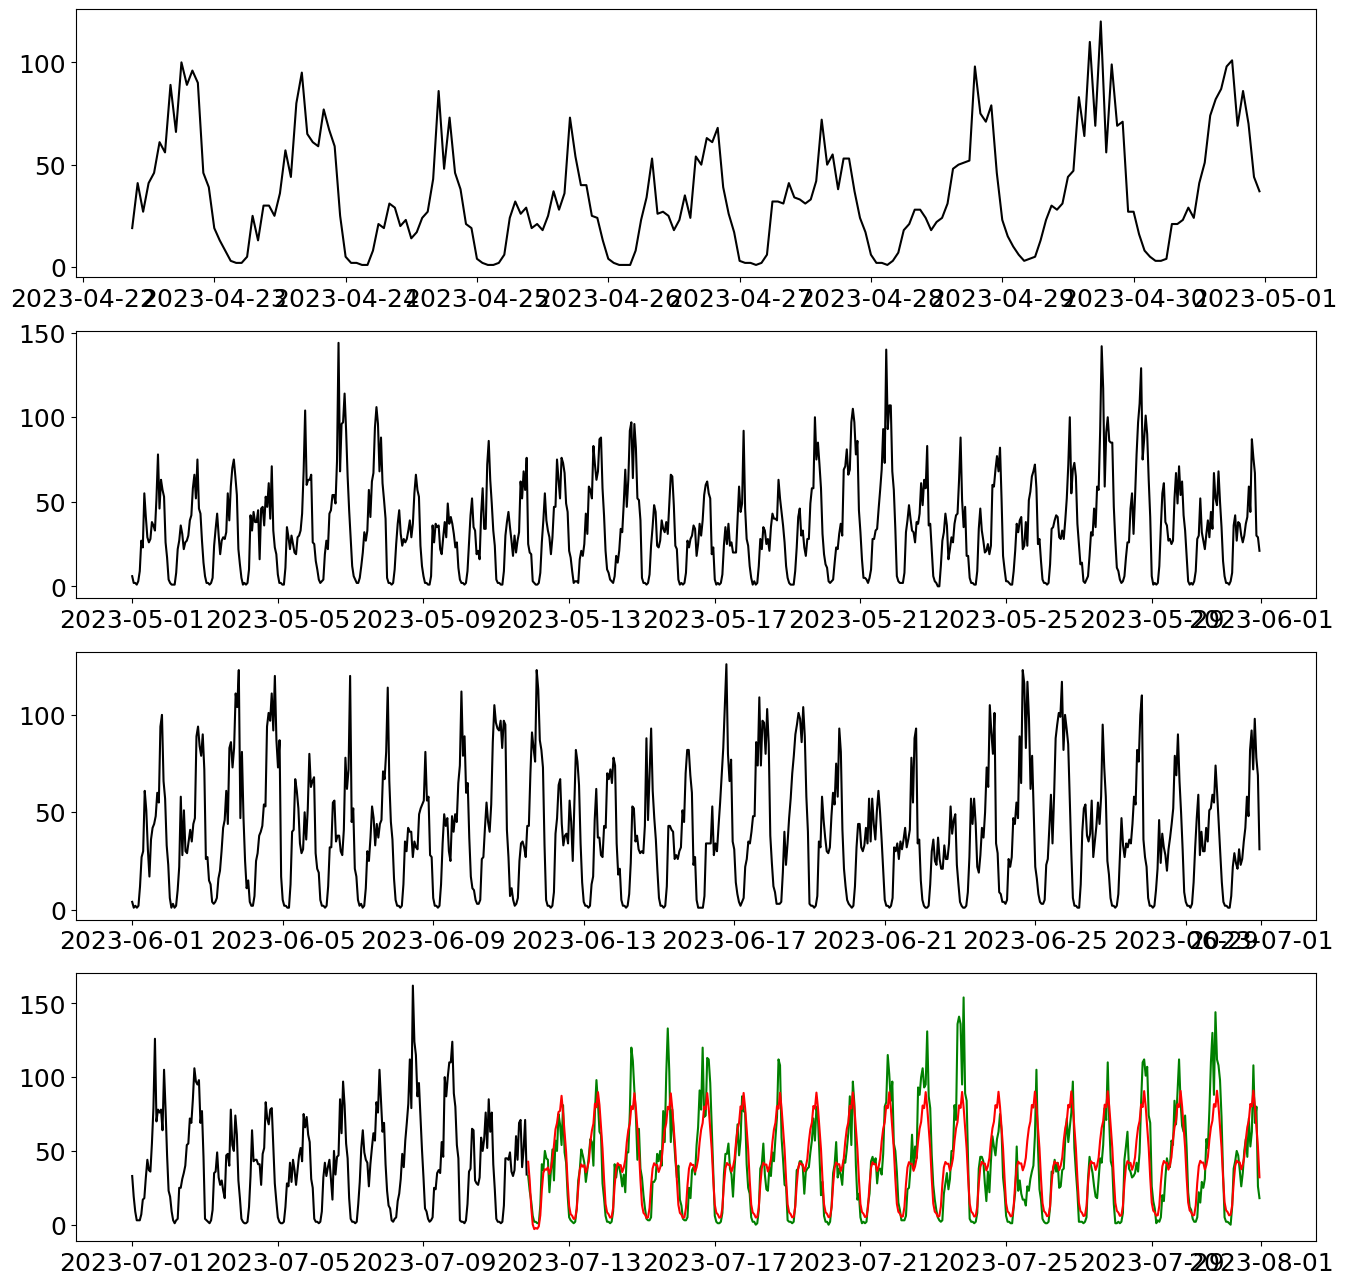

In [180]:
monthes = dem_scoot['start_date'].dt.month.unique()
fig, axs = plt.subplots(nrows=len(monthes), figsize=(16, 16))

for i, month in enumerate(monthes):
    # выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
    monthes_train = train.index.month.unique()
    monthes_test = test.index.month.unique()
    monthes_predictions = predictions.index.month.unique()
    if month in monthes_train:
        data = train[train.index.month == month]
        x = data.index
        y = data.values
        axs[i].plot(x, y, color='black')
    if month in monthes_test:
        data = test[test.index.month == month]
        x = data.index
        y = data.values
        axs[i].plot(x, y, color='green')
    if month in monthes_predictions:
        data = predictions[predictions.index.month == month]
        x = data.index
        y = data.values
        axs[i].plot(x, y, color='red')
    
    # days = x.reset_index().set_index('date').resample('d').sum().reset_index().drop('index', axis=1)['date']
    # xtickvals = [str(date.date().day) + "-" + name_num_day[get_num_of_day_on_week(date)] for date in days]
    

    # axs[i].grid(alpha=0.2)
    # axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
    # axs[i].set_xticks(days)
    # axs[i].set_xlim(days.iloc[0], days.iloc[len(days) - 1] + timedelta(days=1))
    # axs[i].set_ylim(-20, 20)

    # axs[i].set_xticklabels(xtickvals, rotation=90)
    
    # axs[i].set_xlabel('Время')
    # axs[i].set_ylabel('Трафик')
    # axs[i].set_title(f'Спрос в {}')


 
# рассчитаем MSE
print(mean_squared_error(test, predictions))
 
# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))